# **Chemical Space Exploration of QM9 organic materials: Molecular Clustering**
---

## Goal Of The Notebook 

In [1]:
# import libraries
from pathlib import Path
from collections import defaultdict
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from scipy.spatial import distance
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
from rdkit.Chem import Draw, rdmolops
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from openbabel import pybel as pb
import math
from pyscf.data.nist import HARTREE2EV
from matplotlib import cm
%matplotlib inline
%pylab inline
from IPython.display import Image
 
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import SimilarityMaps

ModuleNotFoundError: No module named 'openbabel'

In [5]:
def plot_density(k, data):
    
    global index
    index = []
    global MolCount 
    MolCount = defaultdict(list)
    for j in range(0,k):
        s = data.loc[data['Clusters']==j,'SMILES'].to_list()
        i=0
        for s2 in s:
            i = i+1
        index.append(i)
        MolCount[f'Density Cluster {j+1}'].append(i)

    mean = int(np.array(index).mean())  #int(sum(index) / len(MolCount))
    
    x = []
    for i in range(1,k+1):
        x.append(i)

    font = {'size': 10}
    fig = plt.figure(figsize=(20,8))
    sns.set_style("whitegrid")
    plt.bar(x, index, color='purple', width=0.5)
    plt.axhline(y = mean, color = 'red', linestyle = '--', linewidth=3, label=f'Average number of samples: {mean}')
    plt.ylabel('Number of molecules in each cluster\n', fontsize=24)
    plt.xlabel('\nCluster number', fontsize=24)
    plt.xticks([k for k in range(1,k+1,4)], fontsize=24)
    plt.yticks(fontsize=24)
    plt.grid(linestyle= ':')
    plt.legend(loc='best', fontsize=20)
    plt.tight_layout()
    plt.show()

# def collect_center_ids(centroids, k, predictions, data):

#     # collect centroids indices
#     centers_ids = defaultdict(list)
#     for i in range(k):
#         # get the centroid of cluster i
#         centroid = centroids[i]

#         # get the indices of molecules belonging to cluster i 
#         clusters_mol_id = np.where(predictions == i)[0]

#         # select cep cluster
#         df_cluster = data.iloc[clusters_mol_id]

#         # compute the distances between all molecules in the db and the predicted centroid
#         dists =[]    
#         for j in range(len(df_cluster)):
#             # calculate the Euclidean distances between the centroid and each data point in the cluster
#             dist = distance.euclidean(df_cluster.iloc[j,6:].to_numpy(), centroid) # qm9=6, cep=4, hce=8
#             dists.append(dist)

#         # select the closest molecule to the predicted centroid as the centre of the cluster usin Euclidean distance
#         optim_dist = 10000
#         list_indice = 0
#         current_centroid = {'indice': None, 'distance': None}
#         # iterate over all distances
#         for dist in dists:
#             if dist < optim_dist:
#                 optim_dist = dist
#                 current_centroid.update({'indice': list_indice, 'distance': optim_dist})
#             list_indice += 1

#         center_id = df_cluster['Id'].iloc[current_centroid['indice']]
#         centers_ids[f'Cluster {i}'].append(center_id)
    
#     return centers_ids
from scipy.spatial import distance
import random
def collect_center_ids(centroids, k, predictions, data):
    centers_ids = []
    dists =[]   
    for i, centroid in enumerate(centroids):
        # Filtrer les données du cluster i
        df_cluster = data[predictions == i]
        
        # Vérifiez les dimensions des données
        for j in range(len(df_cluster)):
            point = df_cluster.iloc[j,22:].to_numpy()
            
            # Assurez-vous que point et centroid ont les mêmes dimensions
            if point.shape != centroid.shape:
                print(f"Mismatch in shapes: point={point.shape}, centroid={centroid.shape}")
                continue  # Ignorez si les dimensions ne correspondent pas
            
            # Calculer la distance euclidienne
            dist = distance.euclidean(point, centroid)
            dists.append(dist)

        # Identifiez et stockez l'indice du centre
        if len(dists) > 0:
            center_id = dists.index(min(dists))
            centers_ids.append(center_id)

    return centers_ids

def select_mols(k, data, centers_ids):

    keys = []
    for i in range(k):
        key = f'Cluster {i}'
        keys.append(key)

    ClusterDict = {key: None for key in keys}
    IdDict = {key: None for key in keys}
    for j in range(k):
        smi = data.loc[data['Clusters']==j,'SMILES'].to_list()
        ClusterDict[f'Cluster {j}'] = smi

        id = data.loc[data['Clusters']==j,'Id'].to_list()
        IdDict[f'Cluster {j}'] = id
         

    selected_clusters = [] #43, 14, 45, 27, 29
    for i in range(5):
        position = random.randrange(len(ClusterDict.keys()))
        while position in selected_clusters:
            position = random.randrange(len(ClusterDict.keys()))
        selected_clusters.append(position)

    SelectMol = defaultdict(list)
    SelectId = defaultdict(list)
    # for pos in selected_clusters:
    #     print(pos)
    #     center =  centers_ids[:]
    #     print(center)
    #     center_row = data[data['Id']==center[0]]
    #     print(center_row)
    #     center_smi = center_row['SMILES'].values[0]
    #     center_id = center_row['Id'].values[0]
    #     SelectMol[f'SubCluster_{pos}'].append(center_smi)
    #     SelectId[f'SubCluster_{pos}'].append(center_id)
    for pos in selected_clusters:
        center = centers_ids[pos]  # ✅ Ne pas utiliser `[:]`, juste `centers_ids[pos]`

        print(f"Processing cluster {pos}, center Id: {center}")  # ✅ Debug info

        center_row = data[data['Id'] == center]  # ✅ Suppression de `[0]`

        if not center_row.empty:  # ✅ Vérification si `center_row` contient des données
            center_smi = center_row['SMILES'].values[0]
            center_id = center_row['Id'].values[0]

            SelectMol[f'SubCluster_{pos}'].append(center_smi)
            SelectId[f'SubCluster_{pos}'].append(center_id)
            selected_smi_list.append(center_smi)
        else:
            print(f"⚠️ Aucun résultat pour Id={center} dans `data['Id']`") 

    for pos in selected_clusters:
        for i in range(3): #19
            smi_pos = random.randrange(len(ClusterDict[f'Cluster {pos}'])) 
            smi = ClusterDict[f'Cluster {pos}'][smi_pos]
            id = IdDict[f'Cluster {pos}'][smi_pos]
            while smi in SelectMol[f'SubCluster_{pos}']: 
                smi_pos = random.randrange(len(ClusterDict[f'Cluster {pos}'])) 
                smi = ClusterDict[f'Cluster {pos}'][smi_pos]
                id = IdDict[f'Cluster {pos}'][smi_pos]
            SelectMol[f'SubCluster_{pos}'].append(smi)
            SelectId[f'SubCluster_{pos}'].append(id)

    selected_smi_list = []
    for smi_vect in SelectMol.values():
        for smi in smi_vect:
            selected_smi_list.append(smi)
    
    return ClusterDict, selected_clusters, SelectMol, SelectId, selected_smi_list

def draw_mols(selected_smi_list):

    draw_list = []
    for smi in selected_smi_list:
        mol = Chem.MolFromSmiles(smi)
        mol = Chem.AddHs(mol)
        draw_list.append(mol)
        
    return Draw.MolsToImage(draw_list)

def mol_obj(selected_smi_list, rdkit_obj:bool):

    molecules = []
    if rdkit_obj ==True:
        for smi in selected_smi_list:
            mol = Chem.MolFromSmiles(smi)
            mol = Chem.AddHs(mol)
            molecules.append(mol)
    else:
        for smi in selected_smi_list:
            mol = pb.readstring('smi', smi)
            mol.addh()
            molecules.append(mol)
    
    return molecules
    
def mol_fps(molecules, rdkit_obj:bool):   

    if rdkit_obj ==True:
        fingerprints_list = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=1, nBits=2048) for mol in molecules]
    else:
        fingerprints_list = [mol.calcfp(fptype="ecfp2") for mol in molecules]
        # ob fingerprint types are: ['ecfp0', 'ecfp10', 'ecfp2', 'ecfp4', 'ecfp6', 'ecfp8', 'fp2', 'fp3', 'fp4', 'maccs']
    
    return fingerprints_list

def pairwise_similarity(fingerprints_list, rdkit_obj:bool):
    
    global similarities
    num_fp = len(fingerprints_list)
    similarities = np.zeros((num_fp, num_fp))

    for i in range(num_fp):
        for j in range(num_fp):
            if rdkit_obj == True:
                similarity = DataStructs.TanimotoSimilarity(fingerprints_list[i], fingerprints_list[j])  #Tanimoto, Dice, CosineSimilarity(fps[i], fps[j])
            else:
                similarity = fingerprints_list[i] | fingerprints_list[j]
                
            similarities[i, j] = similarity
            similarities[j, i] = similarities[i, j]

    return similarities

def similarity_map(similarities, labels, annot=True):

    fig = plt.figure(figsize=(15, 15))

    sns.set_theme(font_scale=1)

    # generating the plot
    cmap = sns.diverging_palette(0, 255, as_cmap=True) # Blues   
    sns.heatmap(data=similarities, annot=annot, cmap=cmap, vmin=0, vmax=1, center=0, annot_kws={"fontsize":12}, square=True, xticklabels=labels, yticklabels=labels, linewidths=.7, cbar_kws={"shrink": 0.8})

    if annot == True:
        # Create a list to store the group indices
        group_indices = [0, 3, 6, 9, 12]
        # Create a mask for highlighting the specific regions
        for i in range(len(group_indices)):
            start = group_indices[i]
            end = group_indices[i] + 3

            # Highlight the top border
            plt.hlines(end, start, end, colors='red', linewidths=1.8)
    
            # Highlight the bottom border
            plt.hlines(start, start, end, colors='red', linewidths=1.8)
    
            # Highlight the left border
            plt.vlines(start, start, end, colors='red', linewidths=1.8)
    
            # Highlight the right border
            plt.vlines(end, start, end, colors='red', linewidths=1.8)

    plt.tight_layout()
    plt.show()

In [6]:
#qm9 = pd.read_pickle('../Features/qm9_features/full_qm9.pkl')
#qm9
# convert from Hartree to eV
#ha_2_ev = HARTREE2EV
#qm9['Gap'] = qm9['Gap'].apply(lambda x: x * ha_2_ev)
#qm9['HOMO'] = qm9['HOMO'].apply(lambda x: x * ha_2_ev)
#qm9['LUMO'] = qm9['LUMO'].apply(lambda x: x * ha_2_ev)

#sc_qm9 = qm9[qm9['Gap'] <= 3.5]
#sc_qm9.to_pickle('semiconductor_qm9_clustering/semiconductor_qm9.pkl')
qm9_df= pd.read_pickle('news_PCE_GDB9_mordred.pkl')
qm9= qm9_df
qm9_df

smiles_key                SMILES  HOMO(eV)  HOMO_xtb(eV)  HOMO_DFT(eV)  \
0       gdb 326           O=CC(=O)C=O -7.091287      -11.4928     -6.913515   
1       gdb 723           C1=NN=CN=N1 -6.734818      -10.1217     -6.471639   
2      gdb 1587        CC(=O)C(=O)C=O -6.772914      -11.2156     -6.644032   
3      gdb 1589        NC(=O)C(=O)C=O -6.753866      -11.1089     -6.732598   
4      gdb 2115          O=C1CC=CC1=O -6.386512      -10.8568     -6.429667   
..          ...                   ...       ...           ...           ...   
519  gdb 133853    OC12C3C1N1CC3N=C21 -5.679016       -9.9375     -5.606204   
520  gdb 133854  CC12CC34CC=C(C13)C24 -4.285793       -8.4207     -4.369375   
521  gdb 133858    CC1N2C3C4=CCC13C24 -4.606888       -8.6748     -4.602213   
522  gdb 133864     C1C2CC3OC4CC1C234 -3.771498       -9.9408     -5.314896   
523  gdb 133866     C1C2OC3CC4OC1C234 -4.285793       -8.8939     -4.193755   

     LUMO(eV)  LUMO_xtb(eV)  LUMO_DFT(eV)   GAP(eV)  GAP_xtb(eV)  ...  \
0   -3.959257       -9.1664     -2.552447  3.132031     2.326330  ...   
1   -3.050396       -9.5066     -2.868605  3.687143     0.615100  ...   
2   -3.126588       -9.1516     -2.517150  3.646326     2.064026  ...   
3   -3.311626       -9.9451     -3.399369  3.442240     1.163798  ...   
4   -2.587803       -9.2243     -2.655859  3.798709     1.632489  ...   
..        ...           ...           ...       ...          ...  ...   
519 -2.419092       -8.7319     -2.561790  3.259924     1.205589  ...   
520 -2.481678       -7.7140     -1.807196  1.804115     0.706681  ...   
521 -2.832705       -7.9451     -2.068744  1.774182     0.729718  ...   
522 -1.736086       -8.5677     -1.985876  2.032691     1.373099  ...   
523 -2.046296       -6.8901     -1.147847  2.239497     2.003822  ...   

        TSRW10          MW        AMW  WPath  WPol  Zagreb1  Zagreb2  \
0    29.753427   86.000394  10.750049     31     4     20.0     19.0   
1    30.941317   82.027946  10.253493     27     3     24.0     24.0   
2    32.688753  100.016044   9.092368     46     6     26.0     26.0   
3    32.688753  101.011293  10.101129     46     6     26.0     26.0   
4    47.572444   96.021129   8.729194     40     5     32.0     35.0   
..         ...         ...        ...    ...   ...      ...      ...   
519  66.384029  122.048013   8.136534     67     5     70.0    100.0   
520  62.143269  118.078250   6.214645     70     6     72.0    104.0   
521  61.908503  119.073499   6.615194     71     7     70.0    102.0   
522  44.269937  122.073165   6.424903     72     8     68.0     96.0   
523  44.269937  124.052429   7.297202     72     8     68.0     96.0   

     mZagreb1  mZagreb2      Id  
0    3.611111  1.666667     326  
1    1.500000  1.500000     723  
2    4.472222  1.777778    1587  
3    4.472222  1.777778    1589  
4    2.972222  1.611111    2115  
..        ...       ...     ...  
519  2.118056  1.611111  133853  
520  2.208333  1.597222  133854  
521  2.118056  1.680556  133858  
522  1.506944  1.666667  133864  
523  1.506944  1.666667  133866  

[524 rows x 1046 columns]

## Features correlation heatmap

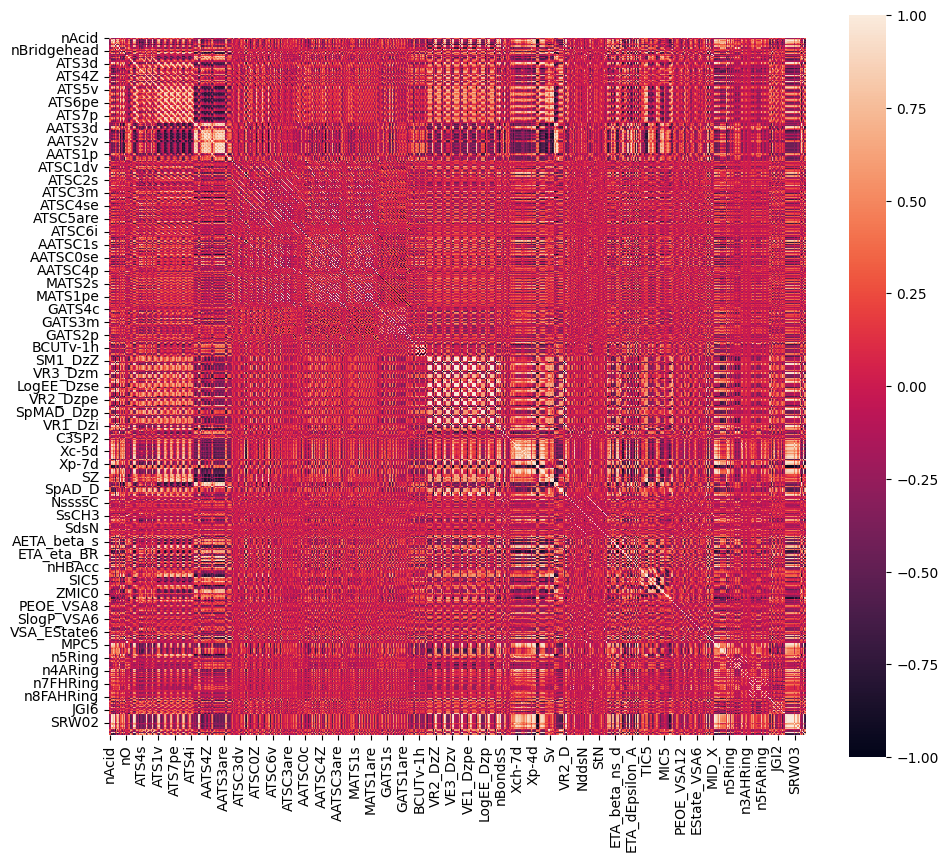

In [7]:
# We calculate correlation with Pearson's coefficient using Pandas:
correlation = qm9[qm9.columns[20:-1]].corr(method='pearson') 
# We create a new figure using matplotlib and set the figure size:
fig=plt.gcf()
fig.set_size_inches(10,10)
# Heatmap of the correlation using Seaborn:
sns.heatmap(correlation, annot=False, square=True, cbar_kws={"shrink": 0.8})
plt.tight_layout()

## Two-dimensional data representation with `t-SNE`

In [16]:
# get numpy arrays of feature vectors
qm9_data = np.array(qm9[qm9.columns[20:-1]].values.tolist())

In [17]:
qm9_data

array([[  0.        ,   0.        ,   6.89897949, ...,  19.        ,
          3.61111111,   1.66666667],
       [  0.        ,   0.        ,   8.        , ...,  24.        ,
          1.5       ,   1.5       ],
       [  0.        ,   0.        ,   7.66298792, ...,  26.        ,
          4.47222222,   1.77777778],
       ...,
       [  0.        ,   1.        ,  11.59100643, ..., 102.        ,
          2.11805556,   1.68055556],
       [  0.        ,   0.        ,  11.3137085 , ...,  96.        ,
          1.50694444,   1.66666667],
       [  0.        ,   0.        ,  11.3137085 , ...,  96.        ,
          1.50694444,   1.66666667]])

In [18]:
# dimension reduction using t-SNE
tsne_qm9 = TSNE(n_components=2, perplexity=30, random_state=30, n_iter=1000).fit_transform(qm9_data)

/home/mvotokps/anaconda3/envs/Patrick/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


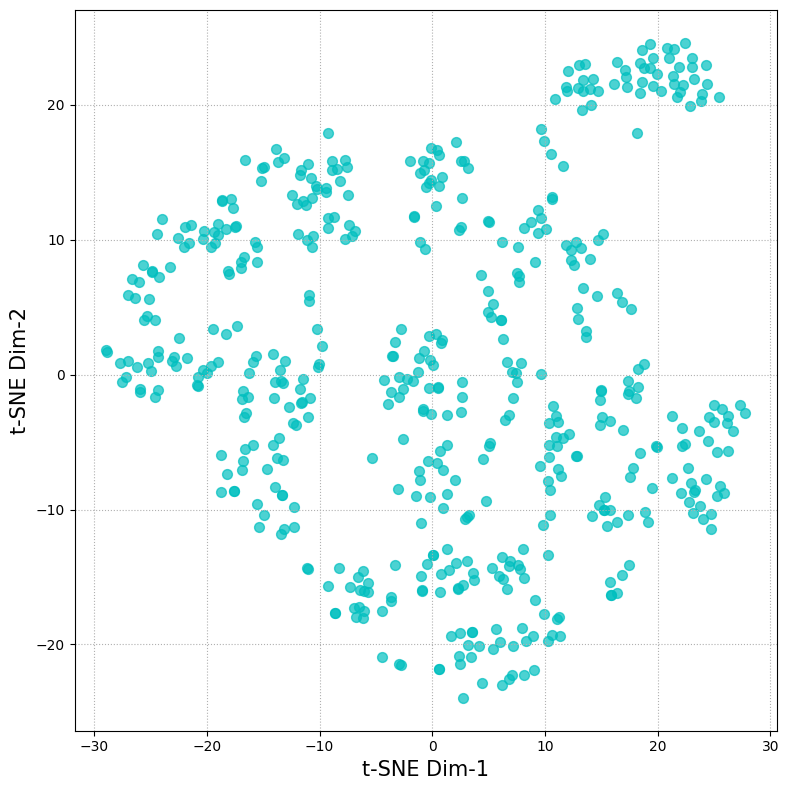

In [9]:
plt.figure(figsize=(8, 8))
# Assuming your class labels are stored in a variable called 'labels'
plt.scatter(tsne_qm9[:, 0], tsne_qm9[:, 1], s=50, color='c', alpha=0.7)
#plt.title("t-SNE Scatter Plot")
plt.grid(linestyle=':')
plt.xlabel("t-SNE Dim-1", fontsize = 15)
plt.ylabel("t-SNE Dim-2", fontsize = 15)
plt.tight_layout()
plt.show()

## Choice of the optimal cluster size using `Silhouette`, `Calinski-Harabasz` and `Davies-Bouldin` evaluation metrics

Load the evaluation outputs from the computation of `choose_k.py` Python code using the observed features of the small molecules. 

In [10]:
qm9_kmeans = pd.read_pickle('./semiconductor_qm9_clustering/kmeans_eval.pkl')
qm9_kmeans.head(3)

N_Clusters  Calinski_Harabasz  Silhouette  Davies_Bouldin
0           5         252.769573    0.274449        1.153236
1          10         198.677872    0.215500        1.299978
2          15         162.256064    0.191023        1.325352

The above dataframe contains the `Calinski-Harabasz`, `Silhouette` and `Davies-Bouldin` scores using the observed QM9 features under different predifined number of clusters (in the range $[5-200]$). We will then visualize them as $x-y$ plots where the y-axis stands for the corresponding evaluation metric, and the x-axis is the diferent number of clusters. As stated by __Hadipour et _al____, the optimized number of clusters in the observed data is the minimum number of clusters where the metric scores become relatively stable.

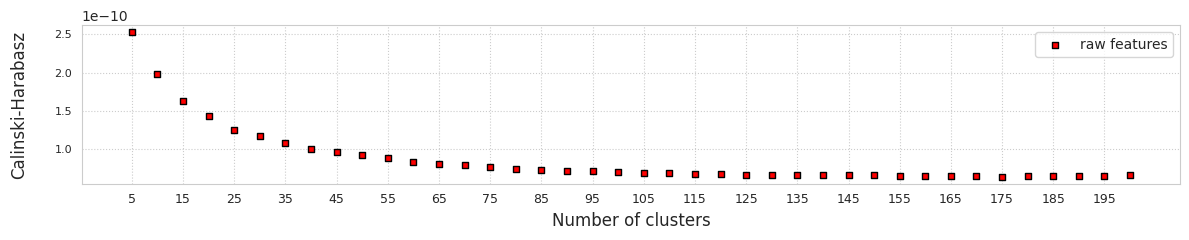

In [11]:
plt.figure(figsize=(12,2.5))
sns.set_style('whitegrid')
plt.scatter(x=[i for i in range(5,205,5)],y=qm9_kmeans['Calinski_Harabasz'][:] * 1e-12,s=15, marker='s',edgecolor='k', color = 'red', label='raw features')
plt.grid(linestyle= ':')
plt.ylabel("Calinski-Harabasz\n",fontsize=12)
plt.xlabel("Number of clusters",fontsize=12)
plt.xticks([i for i in range(5,205,10)],fontsize=9)
plt.yticks(fontsize=8)
plt.legend(loc='best')
plt.tight_layout()

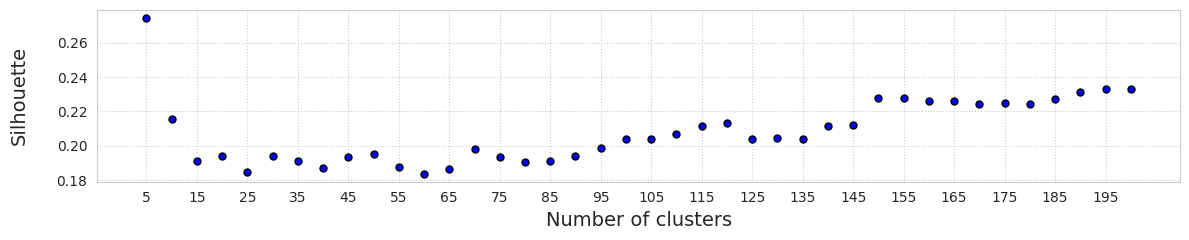

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,2.5))
plt.scatter(x=[i for i in range(5,205,5)], y=qm9_kmeans['Silhouette'][:], 
            s=25, marker='o', edgecolor='k', color='blue', label='raw features')

plt.grid(linestyle=':')
plt.ylabel("Silhouette\n", fontsize=14)
plt.xlabel("Number of clusters", fontsize=14)
plt.xticks([i for i in range(5,205,10)], fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()

# 🔹 Enregistrer l'image en PDF
plt.savefig("silhouette_plot.pdf", format="pdf", bbox_inches="tight")

plt.show()


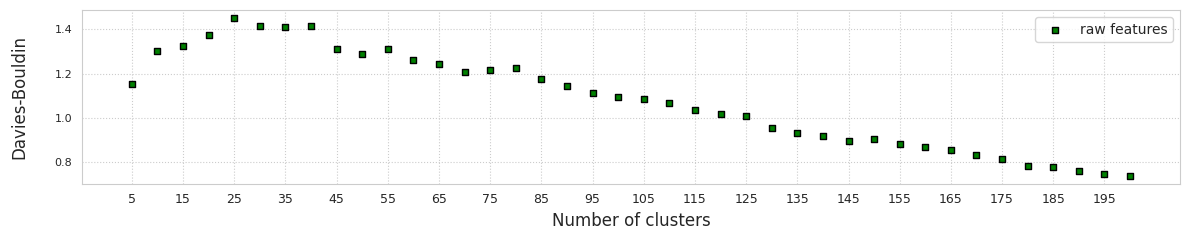

In [13]:
plt.figure(figsize=(12,2.5))
plt.scatter(x=[i for i in range(5,205,5)],y=qm9_kmeans['Davies_Bouldin'][:],s=15, marker='s',edgecolor='k', color = 'green', label='raw features')
plt.grid(linestyle= ':')
plt.ylabel("Davies-Bouldin\n",fontsize=12)
plt.xlabel("Number of clusters",fontsize=12)
plt.xticks([i for i in range(5,205,10)],fontsize=9)
plt.yticks(fontsize=8)
plt.legend(loc='best')
plt.tight_layout()

<div class='alert alert-info'> As shown in the figures above, especially for the silhouette metric, the QM9 feature set achieves relatively stable scores at a cluster size of <code>25</code>. This value will then be used as optimal value of <code>k</code> to build the clustering model.</div>

## Clustering `QM9` data using raw observed features

In [14]:
# instantiate and fit the algorithm 
model = KMeans(init='k-means++', n_clusters=25, n_init='auto', random_state=21).fit(qm9_data)
# perform predictions
qm9_predictions = model.predict(qm9_data)

# get cluster centroids
qm9_centroids = model.cluster_centers_
                    
# evaluate the clustering
# calinski harabasz score
ch = calinski_harabasz_score(qm9_data, qm9_predictions)
print('Calinski-Harabasz Score: %.3f' % ch)

# silhouette score
s = silhouette_score(qm9_data, qm9_predictions)
print('Silhouette Score: %.3f' % s)

# davies bouldin score
db = davies_bouldin_score(qm9_data, qm9_predictions)
print('Davies-Bouldin Score: %.3f' % db)

Calinski-Harabasz Score: 127.381
Silhouette Score: 0.188
Davies-Bouldin Score: 1.495


### 2D representation of clustered data

In [15]:
plt.figure(figsize=(8, 8))
sns.set_style('whitegrid')
# Generate scatter plot for training data
plt.scatter(tsne_qm9[:,0], tsne_qm9[:,1], c=qm9_predictions, marker="o", s=50, alpha=0.7, picker=True)#, picker=True
plt.title(f'Kmeans clustering', fontsize = 15)
plt.grid(linestyle=':')
plt.xlabel("t-SNE Dim-1", fontsize = 15)
plt.ylabel("t-SNE Dim-2", fontsize = 15)
plt.tight_layout()
plt.show()

NameError: name 'tsne_qm9' is not defined

<Figure size 800x800 with 0 Axes>

### Visualization of clusters densities: The number of samples in each cluster

In [16]:
df = qm9.copy()

In [17]:
df.insert(1, 'Clusters', qm9_predictions)
df

smiles_key  Clusters                SMILES  HOMO(eV)  HOMO_xtb(eV)  \
0       gdb 326        16           O=CC(=O)C=O -7.091287      -11.4928   
1       gdb 723        16           C1=NN=CN=N1 -6.734818      -10.1217   
2      gdb 1587        16        CC(=O)C(=O)C=O -6.772914      -11.2156   
3      gdb 1589        16        NC(=O)C(=O)C=O -6.753866      -11.1089   
4      gdb 2115        16          O=C1CC=CC1=O -6.386512      -10.8568   
..          ...       ...                   ...       ...           ...   
519  gdb 133853         6    OC12C3C1N1CC3N=C21 -5.679016       -9.9375   
520  gdb 133854         3  CC12CC34CC=C(C13)C24 -4.285793       -8.4207   
521  gdb 133858        24    CC1N2C3C4=CCC13C24 -4.606888       -8.6748   
522  gdb 133864        24     C1C2CC3OC4CC1C234 -3.771498       -9.9408   
523  gdb 133866        15     C1C2OC3CC4OC1C234 -4.285793       -8.8939   

     HOMO_DFT(eV)  LUMO(eV)  LUMO_xtb(eV)  LUMO_DFT(eV)   GAP(eV)  ...  \
0       -6.913515 -3.959257       -9.1664     -2.552447  3.132031  ...   
1       -6.471639 -3.050396       -9.5066     -2.868605  3.687143  ...   
2       -6.644032 -3.126588       -9.1516     -2.517150  3.646326  ...   
3       -6.732598 -3.311626       -9.9451     -3.399369  3.442240  ...   
4       -6.429667 -2.587803       -9.2243     -2.655859  3.798709  ...   
..            ...       ...           ...           ...       ...  ...   
519     -5.606204 -2.419092       -8.7319     -2.561790  3.259924  ...   
520     -4.369375 -2.481678       -7.7140     -1.807196  1.804115  ...   
521     -4.602213 -2.832705       -7.9451     -2.068744  1.774182  ...   
522     -5.314896 -1.736086       -8.5677     -1.985876  2.032691  ...   
523     -4.193755 -2.046296       -6.8901     -1.147847  2.239497  ...   

        TSRW10          MW        AMW  WPath  WPol  Zagreb1  Zagreb2  \
0    29.753427   86.000394  10.750049     31     4     20.0     19.0   
1    30.941317   82.027946  10.253493     27     3     24.0     24.0   
2    32.688753  100.016044   9.092368     46     6     26.0     26.0   
3    32.688753  101.011293  10.101129     46     6     26.0     26.0   
4    47.572444   96.021129   8.729194     40     5     32.0     35.0   
..         ...         ...        ...    ...   ...      ...      ...   
519  66.384029  122.048013   8.136534     67     5     70.0    100.0   
520  62.143269  118.078250   6.214645     70     6     72.0    104.0   
521  61.908503  119.073499   6.615194     71     7     70.0    102.0   
522  44.269937  122.073165   6.424903     72     8     68.0     96.0   
523  44.269937  124.052429   7.297202     72     8     68.0     96.0   

     mZagreb1  mZagreb2      Id  
0    3.611111  1.666667     326  
1    1.500000  1.500000     723  
2    4.472222  1.777778    1587  
3    4.472222  1.777778    1589  
4    2.972222  1.611111    2115  
..        ...       ...     ...  
519  2.118056  1.611111  133853  
520  2.208333  1.597222  133854  
521  2.118056  1.680556  133858  
522  1.506944  1.666667  133864  
523  1.506944  1.666667  133866  

[524 rows x 1047 columns]

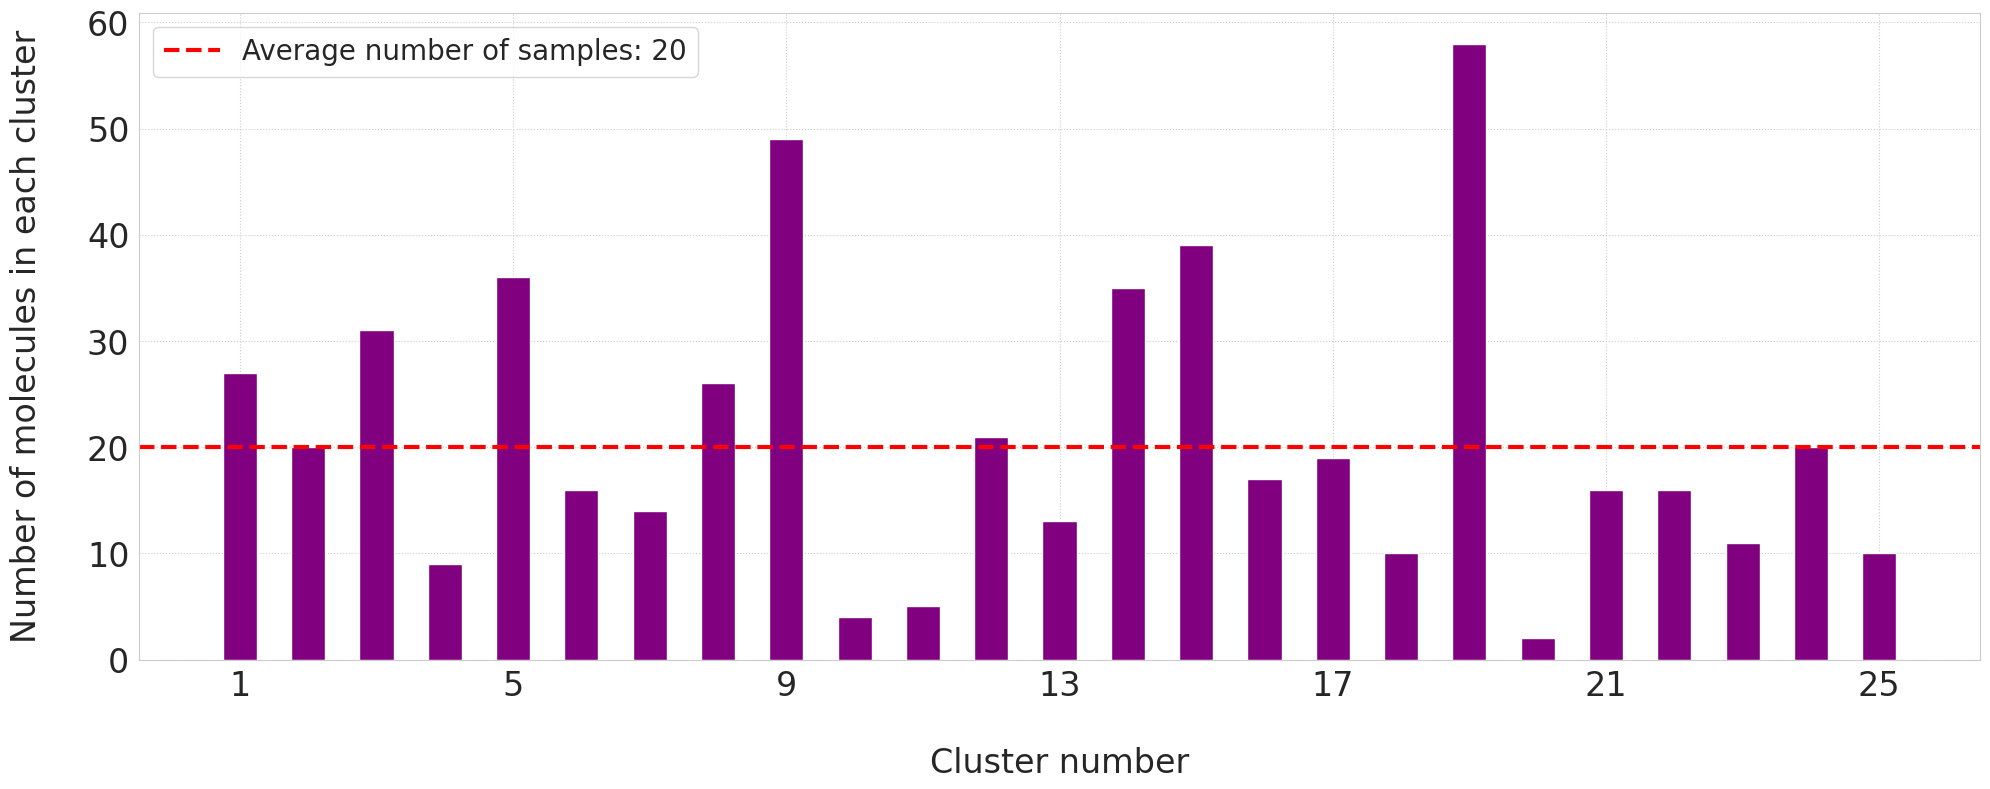

⚠️ Attention : `plot_density()` ne retourne pas une figure Matplotlib.


In [18]:
# Générer la figure avec la densité des clusters
fig = plot_density(k=25, data=df)

# Vérifier si `plot_density()` retourne bien une figure
if isinstance(fig, plt.Figure):
    fig.savefig("cluster_number.pdf", format="pdf", bbox_inches="tight")
    print("✅ Image enregistrée sous 'cluster_number.pdf'")
else:
    print("⚠️ Attention : `plot_density()` ne retourne pas une figure Matplotlib.")


In [19]:
print(qm9_centroids)

[[ 2.59259259e-01  1.03703704e+00  9.87571640e+00 ...  3.41851852e+01
   4.62962963e+00  2.19958848e+00]
 [ 2.50000000e-01  6.00000000e-01  1.09420498e+01 ...  4.82000000e+01
   3.92118056e+00  2.14722222e+00]
 [ 1.93548387e-01  5.48387097e-01  1.08953336e+01 ...  4.57741935e+01
   3.82101254e+00  2.07526882e+00]
 ...
 [ 8.18181818e-01  1.18181818e+00  1.04957647e+01 ...  4.64545455e+01
   4.31691919e+00  2.16035354e+00]
 [ 4.00000000e-01  1.80000000e+00  1.02233286e+01 ...  3.51000000e+01
   4.80972222e+00  2.29861111e+00]
 [-2.77555756e-17  5.00000000e-01  1.21460789e+01 ...  9.98000000e+01
   1.90069444e+00  1.64027778e+00]]


In [20]:
density = np.array(index)
max_dens = density.max()
min_dens = density.min()

print('The clustering process yields 25 clusters with a mean density of {} samples per cluster.\nThe cluster 9 has the maximum density of {} samples, \
while the clusters 15 and 22 have the minimum density of {} samples.'.format(int(density.mean()), max_dens, min_dens))

The clustering process yields 25 clusters with a mean density of 20 samples per cluster.
The cluster 9 has the maximum density of 58 samples, while the clusters 15 and 22 have the minimum density of 2 samples.


In [21]:

df.shape

(524, 1047)

In [22]:
df

smiles_key  Clusters                SMILES  HOMO(eV)  HOMO_xtb(eV)  \
0       gdb 326        16           O=CC(=O)C=O -7.091287      -11.4928   
1       gdb 723        16           C1=NN=CN=N1 -6.734818      -10.1217   
2      gdb 1587        16        CC(=O)C(=O)C=O -6.772914      -11.2156   
3      gdb 1589        16        NC(=O)C(=O)C=O -6.753866      -11.1089   
4      gdb 2115        16          O=C1CC=CC1=O -6.386512      -10.8568   
..          ...       ...                   ...       ...           ...   
519  gdb 133853         6    OC12C3C1N1CC3N=C21 -5.679016       -9.9375   
520  gdb 133854         3  CC12CC34CC=C(C13)C24 -4.285793       -8.4207   
521  gdb 133858        24    CC1N2C3C4=CCC13C24 -4.606888       -8.6748   
522  gdb 133864        24     C1C2CC3OC4CC1C234 -3.771498       -9.9408   
523  gdb 133866        15     C1C2OC3CC4OC1C234 -4.285793       -8.8939   

     HOMO_DFT(eV)  LUMO(eV)  LUMO_xtb(eV)  LUMO_DFT(eV)   GAP(eV)  ...  \
0       -6.913515 -3.959257       -9.1664     -2.552447  3.132031  ...   
1       -6.471639 -3.050396       -9.5066     -2.868605  3.687143  ...   
2       -6.644032 -3.126588       -9.1516     -2.517150  3.646326  ...   
3       -6.732598 -3.311626       -9.9451     -3.399369  3.442240  ...   
4       -6.429667 -2.587803       -9.2243     -2.655859  3.798709  ...   
..            ...       ...           ...           ...       ...  ...   
519     -5.606204 -2.419092       -8.7319     -2.561790  3.259924  ...   
520     -4.369375 -2.481678       -7.7140     -1.807196  1.804115  ...   
521     -4.602213 -2.832705       -7.9451     -2.068744  1.774182  ...   
522     -5.314896 -1.736086       -8.5677     -1.985876  2.032691  ...   
523     -4.193755 -2.046296       -6.8901     -1.147847  2.239497  ...   

        TSRW10          MW        AMW  WPath  WPol  Zagreb1  Zagreb2  \
0    29.753427   86.000394  10.750049     31     4     20.0     19.0   
1    30.941317   82.027946  10.253493     27     3     24.0     24.0   
2    32.688753  100.016044   9.092368     46     6     26.0     26.0   
3    32.688753  101.011293  10.101129     46     6     26.0     26.0   
4    47.572444   96.021129   8.729194     40     5     32.0     35.0   
..         ...         ...        ...    ...   ...      ...      ...   
519  66.384029  122.048013   8.136534     67     5     70.0    100.0   
520  62.143269  118.078250   6.214645     70     6     72.0    104.0   
521  61.908503  119.073499   6.615194     71     7     70.0    102.0   
522  44.269937  122.073165   6.424903     72     8     68.0     96.0   
523  44.269937  124.052429   7.297202     72     8     68.0     96.0   

     mZagreb1  mZagreb2      Id  
0    3.611111  1.666667     326  
1    1.500000  1.500000     723  
2    4.472222  1.777778    1587  
3    4.472222  1.777778    1589  
4    2.972222  1.611111    2115  
..        ...       ...     ...  
519  2.118056  1.611111  133853  
520  2.208333  1.597222  133854  
521  2.118056  1.680556  133858  
522  1.506944  1.666667  133864  
523  1.506944  1.666667  133866  

[524 rows x 1047 columns]

In [23]:
centers_ids = collect_center_ids(k=25, centroids=qm9_centroids,predictions=qm9_predictions, data=df)

In [24]:
centers_ids

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 364,
 364,
 364,
 364,
 364,
 364,
 364,
 364,
 364]

In [25]:
a=len(centers_ids)
a

25

In [26]:
ClusterDict, selected_clusters, SelectMol, SelectId, selected_smi_list = select_mols(k=25, data=df, centers_ids=centers_ids)
selected_clusters

Processing cluster 11, center Id: 0
⚠️ Aucun résultat pour Id=0 dans `data['Id']`
Processing cluster 8, center Id: 0
⚠️ Aucun résultat pour Id=0 dans `data['Id']`
Processing cluster 1, center Id: 0
⚠️ Aucun résultat pour Id=0 dans `data['Id']`
Processing cluster 13, center Id: 0
⚠️ Aucun résultat pour Id=0 dans `data['Id']`
Processing cluster 21, center Id: 364
⚠️ Aucun résultat pour Id=364 dans `data['Id']`


[11, 8, 1, 13, 21]

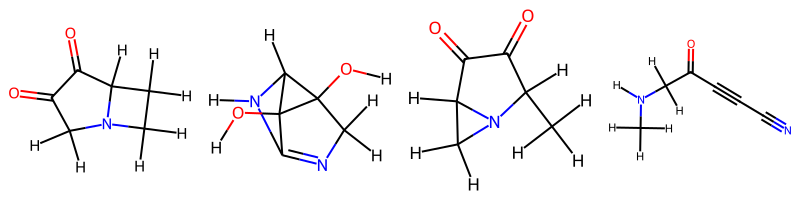

In [27]:
draw_mols(selected_smi_list[:4])

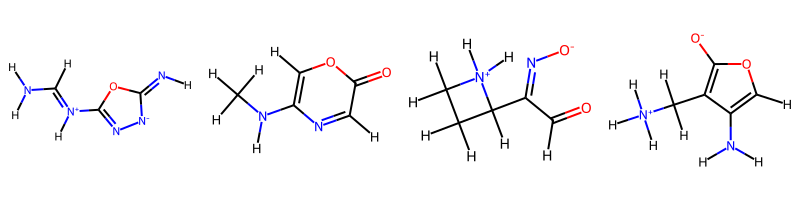

In [28]:
draw_mols(selected_smi_list[4:8])

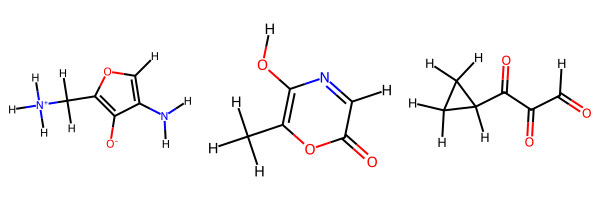

In [29]:
draw_mols(selected_smi_list[8:11])

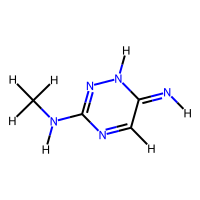

In [30]:
draw_mols(selected_smi_list[14:15])

Nombre de molécules : 15
Taille de la matrice de similarité : (15, 15)


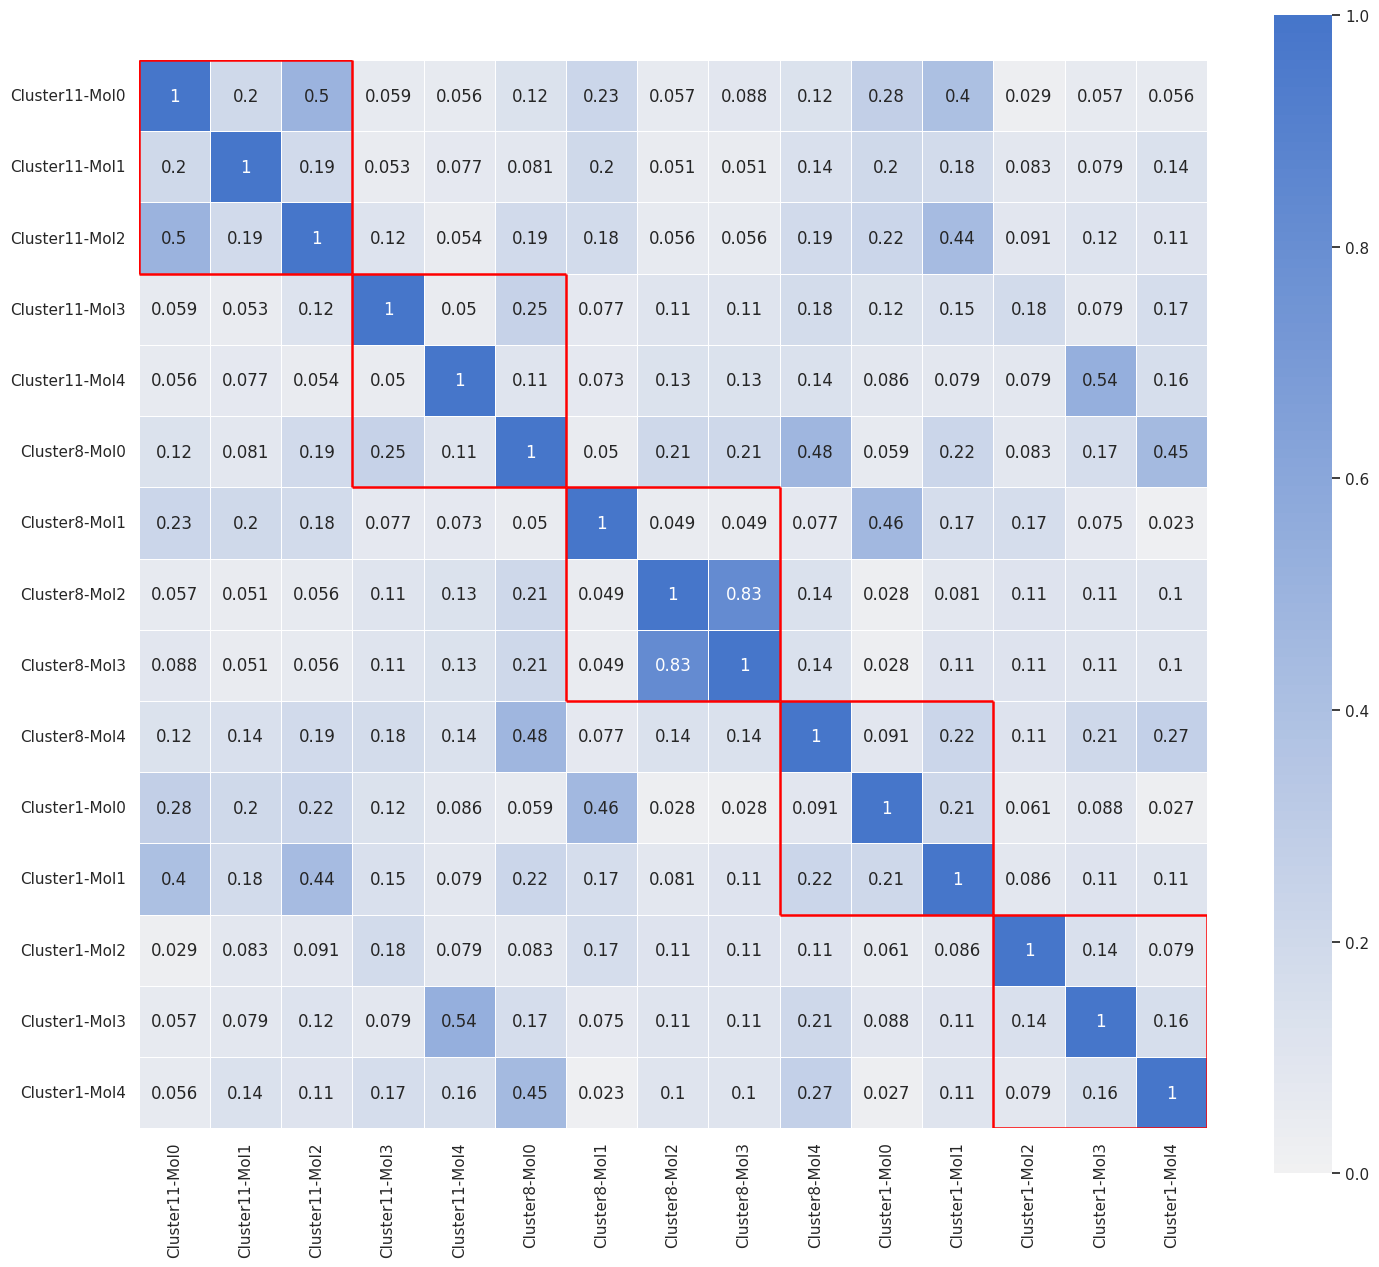

In [31]:
# Générer les objets moléculaires RDKit
molecules = mol_obj(selected_smi_list, rdkit_obj=True)

# Générer les empreintes moléculaires
fingerprints_list = mol_fps(molecules=molecules, rdkit_obj=True)

# Calculer la similarité en paires
similarities = pairwise_similarity(fingerprints_list, rdkit_obj=True)

# Vérification des dimensions
num_molecules = len(molecules)  # Nombre réel de molécules

print(f"Nombre de molécules : {num_molecules}")  # Debug
print(f"Taille de la matrice de similarité : {similarities.shape}")  # Debug

# Ajustement de la liste `labels` pour correspondre à `num_molecules`
labels = [f'Cluster{cluster}-Mol{i}' for cluster in selected_clusters for i in range(5)]
labels = labels[:num_molecules]  # Ajuste la liste des labels si nécessaire

# Vérification finale
assert similarities.shape[0] == similarities.shape[1] == len(labels), "Erreur : La taille de la matrice ne correspond pas aux labels."

# Affichage de la carte de similarité
similarity_map(similarities, labels, annot=True)


In [32]:
with open('semiconductor_qm9_clustering/cluster_dict.pkl', 'wb') as f:
    pickle.dump(ClusterDict, f)

np.save('semiconductor_qm9_clustering/selected_clusters.npy', selected_clusters)

cluster_df = pd.DataFrame(SelectMol)
cluster_df.to_pickle('semiconductor_qm9_clustering/SelectMolecules.pkl')

cluster_df = pd.DataFrame(SelectId)
cluster_df.to_pickle('semiconductor_qm9_clustering/SelectIds.pkl')

## Saved Results

In [33]:
cluster_dict = Path.cwd() / 'semiconductor_qm9_clustering' / 'cluster_dict.pkl'
ClusterDict = pd.read_pickle(cluster_dict)

In [34]:
sel_clust = Path.cwd() / 'semiconductor_qm9_clustering' / 'selected_clusters.npy'
selected_clusters = list(np.load(sel_clust))
selected_clusters

[11, 8, 1, 13, 21]

In [35]:
sel_mol = Path.cwd() / 'semiconductor_qm9_clustering' /  'SelectMolecules.pkl'
cluster_df = pd.read_pickle(sel_mol)
cluster_df

SubCluster_11             SubCluster_8             SubCluster_1  \
0    O=C1CN2CCC2C1=O           CNCC(=O)C#CC#N  [O-]N=C(C=O)C1CC[NH2+]1   
1   OC12CN=C3NC1C23O  NC=[NH+]C1=N[N-]C(=N)O1  NC1=COC([O-])=C1C[NH3+]   
2  CC1N2CC2C(=O)C1=O         CNC1=COC(=O)C=N1  NC1=COC(C[NH3+])=C1[O-]   

        SubCluster_13             SubCluster_21  
0  CC1=C(O)N=CC(=O)O1  CC(=N[O-])C#CC(N)=[NH2+]  
1  O=CC(=O)C(=O)C1CC1   CC1=N[N-]C(=N1)[NH+]=CN  
2     COC1OCC(=O)C1=O          CNC1=NNC(=N)C=N1

In [36]:
selected_smi_list = []
for key in cluster_df.keys():
    print(key)
    for smi_vect in cluster_df[key].values:
        selected_smi_list.append(smi_vect)
print(selected_smi_list)

SubCluster_11
SubCluster_8
SubCluster_1
SubCluster_13
SubCluster_21
['O=C1CN2CCC2C1=O', 'OC12CN=C3NC1C23O', 'CC1N2CC2C(=O)C1=O', 'CNCC(=O)C#CC#N', 'NC=[NH+]C1=N[N-]C(=N)O1', 'CNC1=COC(=O)C=N1', '[O-]N=C(C=O)C1CC[NH2+]1', 'NC1=COC([O-])=C1C[NH3+]', 'NC1=COC(C[NH3+])=C1[O-]', 'CC1=C(O)N=CC(=O)O1', 'O=CC(=O)C(=O)C1CC1', 'COC1OCC(=O)C1=O', 'CC(=N[O-])C#CC(N)=[NH2+]', 'CC1=N[N-]C(=N1)[NH+]=CN', 'CNC1=NNC(=N)C=N1']


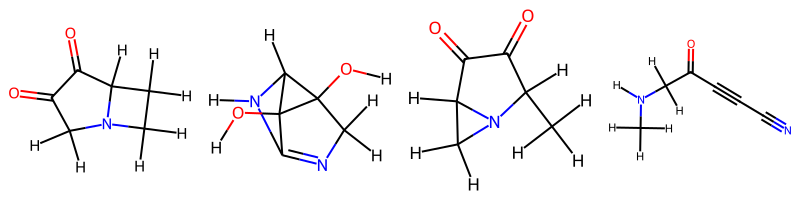

In [37]:
draw_mols(selected_smi_list[:4])

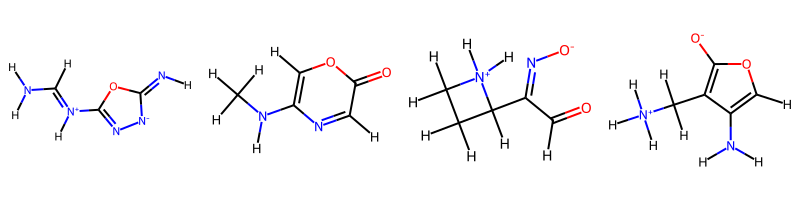

In [38]:
draw_mols(selected_smi_list[4:8])

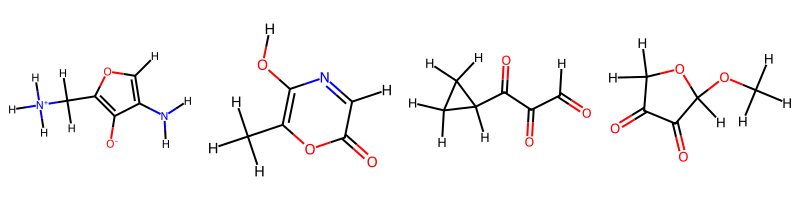

In [39]:
draw_mols(selected_smi_list[8:12])

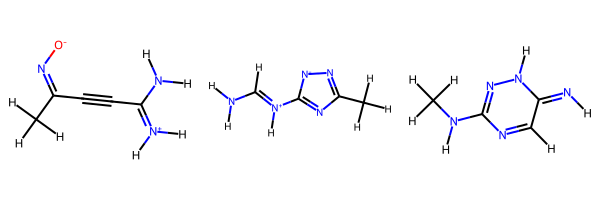

In [40]:
draw_mols(selected_smi_list[12:16])

In [41]:
selected_smi_list

['O=C1CN2CCC2C1=O',
 'OC12CN=C3NC1C23O',
 'CC1N2CC2C(=O)C1=O',
 'CNCC(=O)C#CC#N',
 'NC=[NH+]C1=N[N-]C(=N)O1',
 'CNC1=COC(=O)C=N1',
 '[O-]N=C(C=O)C1CC[NH2+]1',
 'NC1=COC([O-])=C1C[NH3+]',
 'NC1=COC(C[NH3+])=C1[O-]',
 'CC1=C(O)N=CC(=O)O1',
 'O=CC(=O)C(=O)C1CC1',
 'COC1OCC(=O)C1=O',
 'CC(=N[O-])C#CC(N)=[NH2+]',
 'CC1=N[N-]C(=N1)[NH+]=CN',
 'CNC1=NNC(=N)C=N1']

In [42]:
selected_clusters

[11, 8, 1, 13, 21]

In [43]:
similarities

array([[1.        , 0.2       , 0.5       , 0.05882353, 0.05555556,
        0.125     , 0.22580645, 0.05714286, 0.08823529, 0.125     ,
        0.28      , 0.4       , 0.02941176, 0.05714286, 0.05555556],
       [0.2       , 1.        , 0.19354839, 0.05263158, 0.07692308,
        0.08108108, 0.2       , 0.05128205, 0.05128205, 0.14285714,
        0.2       , 0.18181818, 0.08333333, 0.07894737, 0.13513514],
       [0.5       , 0.19354839, 1.        , 0.12121212, 0.05405405,
        0.19354839, 0.18181818, 0.05555556, 0.05555556, 0.19354839,
        0.22222222, 0.44      , 0.09090909, 0.11764706, 0.11428571],
       [0.05882353, 0.05263158, 0.12121212, 1.        , 0.05      ,
        0.25      , 0.07692308, 0.10810811, 0.10810811, 0.17647059,
        0.125     , 0.14705882, 0.18181818, 0.07894737, 0.16666667],
       [0.05555556, 0.07692308, 0.05405405, 0.05      , 1.        ,
        0.10526316, 0.07317073, 0.13157895, 0.13157895, 0.13513514,
        0.08571429, 0.07894737, 0.07894737, 

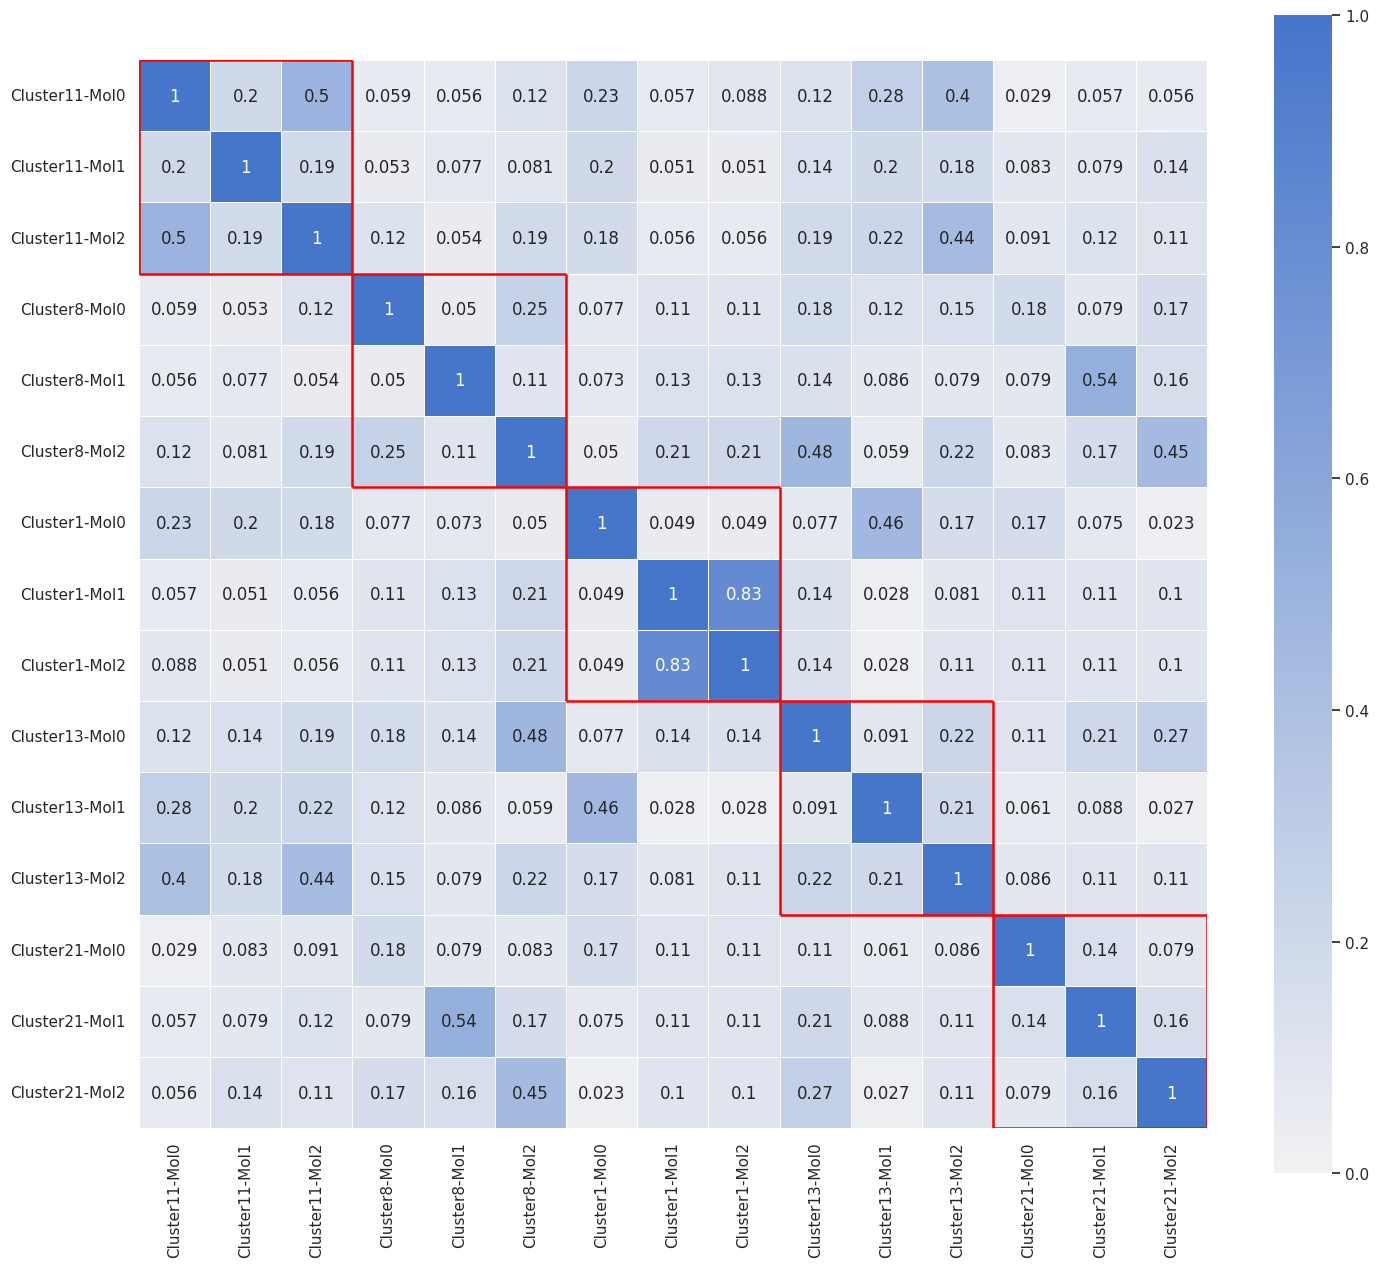

In [44]:
molecules = mol_obj(selected_smi_list, rdkit_obj=True)
fingerprints_list = mol_fps(molecules=molecules, rdkit_obj=True)
similarities = pairwise_similarity(fingerprints_list, rdkit_obj=True)
labels = [f'Cluster{cluster}-Mol{i}' for cluster in selected_clusters for i in range(3)]
assert similarities.shape[0] == similarities.shape[0] == len(labels)
similarity_map(similarities, labels, annot=True)

Nombre de molécules : 15
Taille de la matrice de similarité : (15, 15)


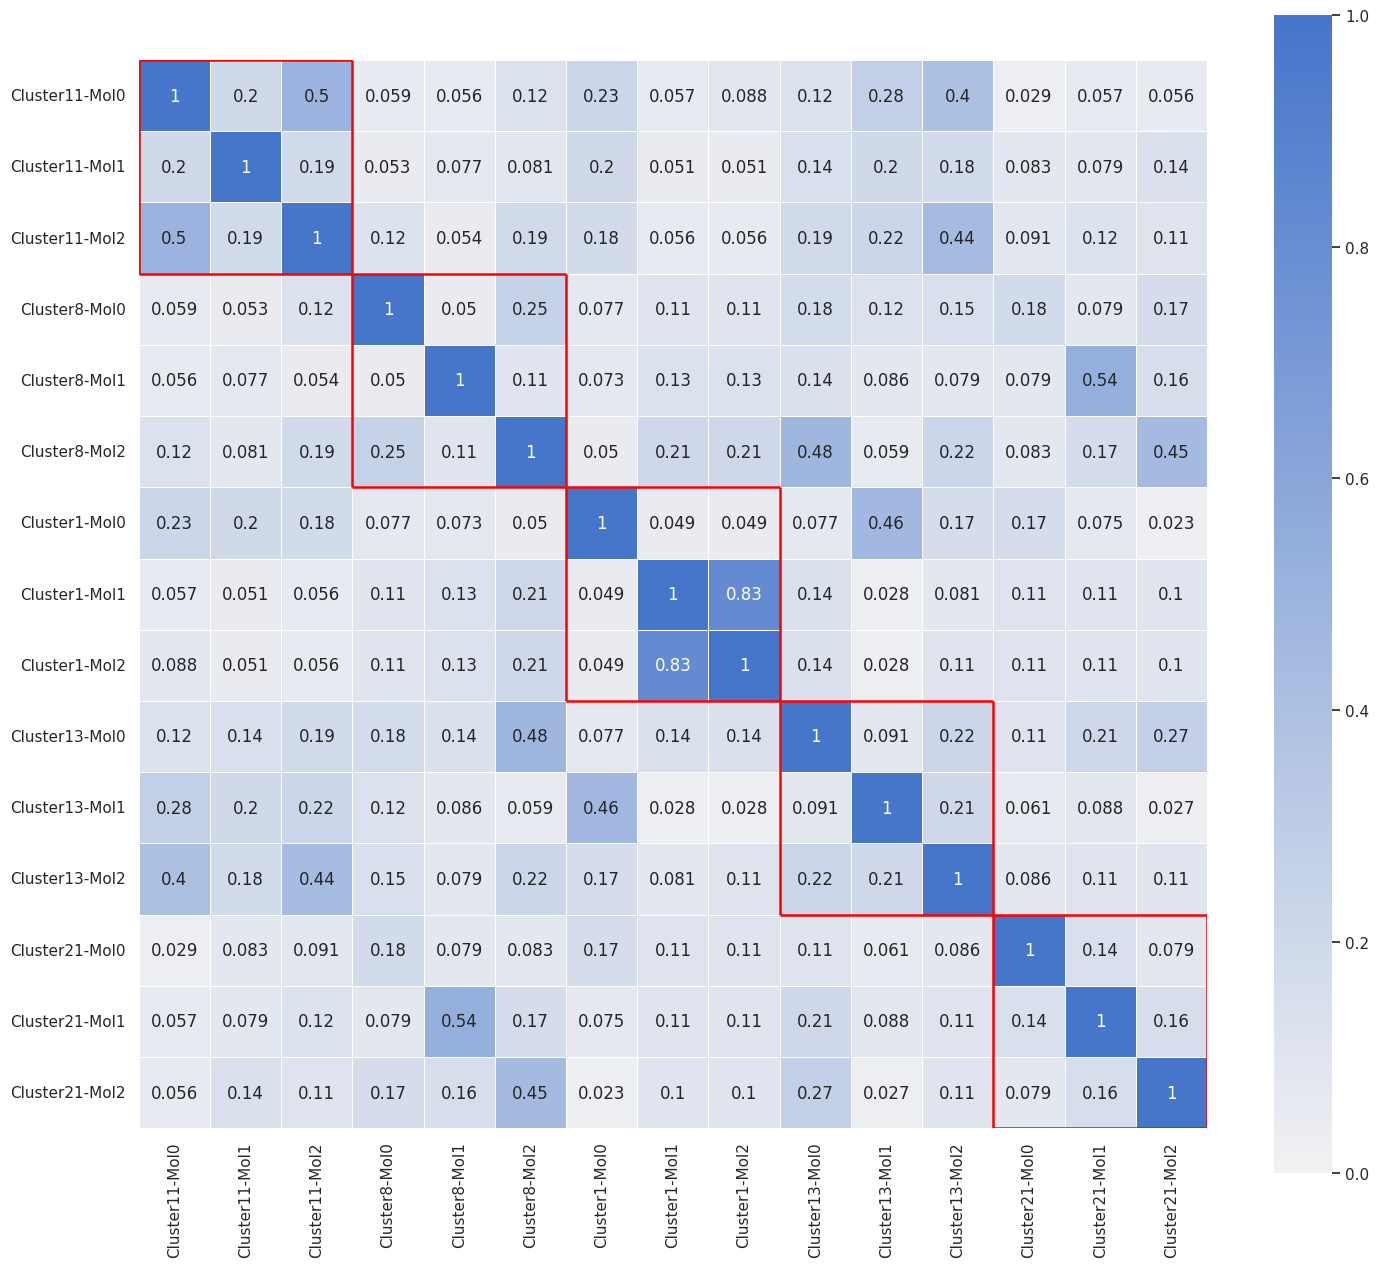

In [45]:
import matplotlib.pyplot as plt

# Générer les objets moléculaires RDKit
molecules = mol_obj(selected_smi_list, rdkit_obj=True)

# Générer les empreintes moléculaires
fingerprints_list = mol_fps(molecules=molecules, rdkit_obj=True)

# Calculer la similarité en paires
similarities = pairwise_similarity(fingerprints_list, rdkit_obj=True)

# Vérification des dimensions
num_molecules = len(molecules)  # Nombre réel de molécules

print(f"Nombre de molécules : {num_molecules}")  # Debug
print(f"Taille de la matrice de similarité : {similarities.shape}")  # Debug

# Ajustement de la liste `labels` pour correspondre à `num_molecules`
# Assurez-vous que selected_clusters contient les 5 clusters
labels = [f'Cluster{cluster}-Mol{i}' for cluster in selected_clusters for i in range(3)]
labels = labels[:num_molecules]  # Ajuste la liste des labels si nécessaire

# Vérification finale
assert similarities.shape[0] == similarities.shape[1] == len(labels), "Erreur : La taille de la matrice ne correspond pas aux labels."


similarity_map(similarities, labels, annot=True)



Nombre de molécules : 15
Taille de la matrice de similarité : (15, 15)


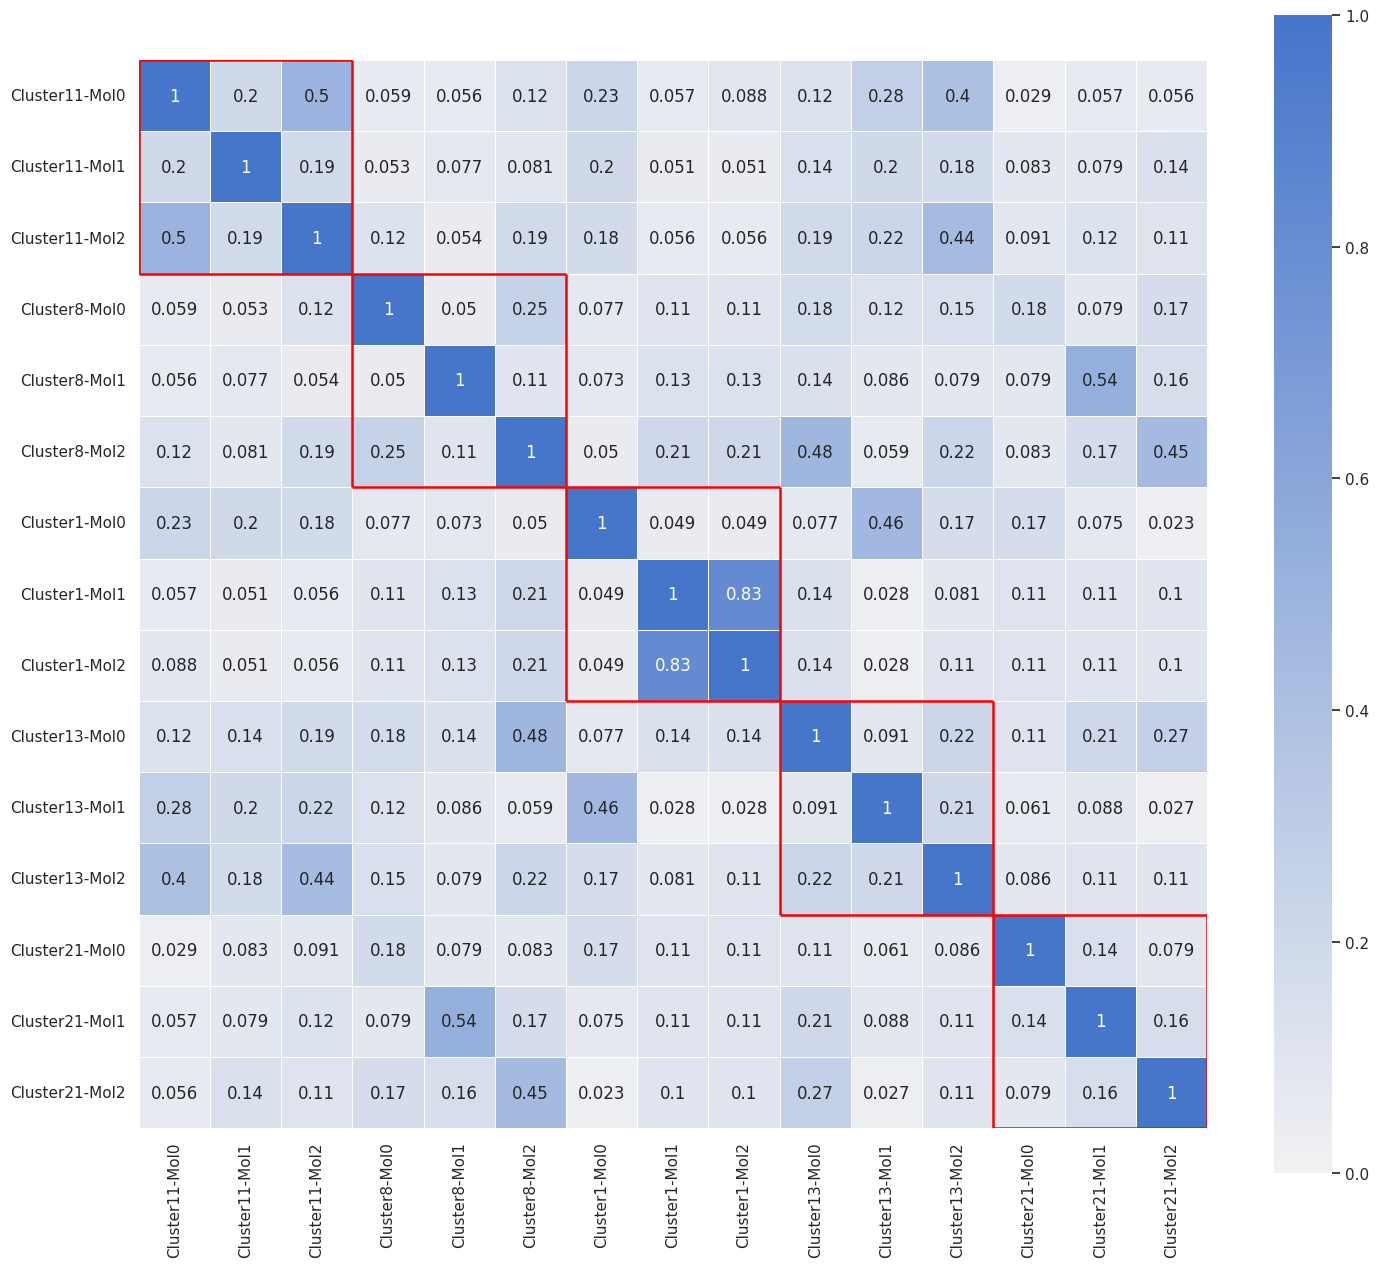

In [46]:
# Générer les objets moléculaires RDKit
molecules = mol_obj(selected_smi_list, rdkit_obj=True)

# Générer les empreintes moléculaires
fingerprints_list = mol_fps(molecules=molecules, rdkit_obj=True)

# Calculer la similarité en paires
similarities = pairwise_similarity(fingerprints_list, rdkit_obj=True)

# Vérification des dimensions
num_molecules = len(molecules)  # Nombre réel de molécules

print(f"Nombre de molécules : {num_molecules}")  # Debug
print(f"Taille de la matrice de similarité : {similarities.shape}")  # Debug

# Ajustement de la liste `labels` pour correspondre à `num_molecules`
labels = [f'Cluster{cluster}-Mol{i}' for cluster in selected_clusters for i in range(3)]
labels = labels[:num_molecules]  # Ajuste la liste des labels si nécessaire

# Vérification finale
assert similarities.shape[0] == similarities.shape[1] == len(labels), "Erreur : La taille de la matrice ne correspond pas aux labels."

# Affichage de la carte de similarité
similarity_map(similarities, labels, annot=True)

## Molecular Selection

### Observing the cluster variance

In [47]:
print(df.dtypes)


smiles_key       object
Clusters          int32
SMILES           object
HOMO(eV)        float64
HOMO_xtb(eV)    float64
                 ...   
Zagreb1         float64
Zagreb2         float64
mZagreb1        float64
mZagreb2        float64
Id                int64
Length: 1047, dtype: object


The clustering process yields 25 clusters with a mean variance of 0.4859 per cluster.
The cluster 16 has the maximum variance of 0.9407, while the clusters 19 have the minimum variance of 0.1644.


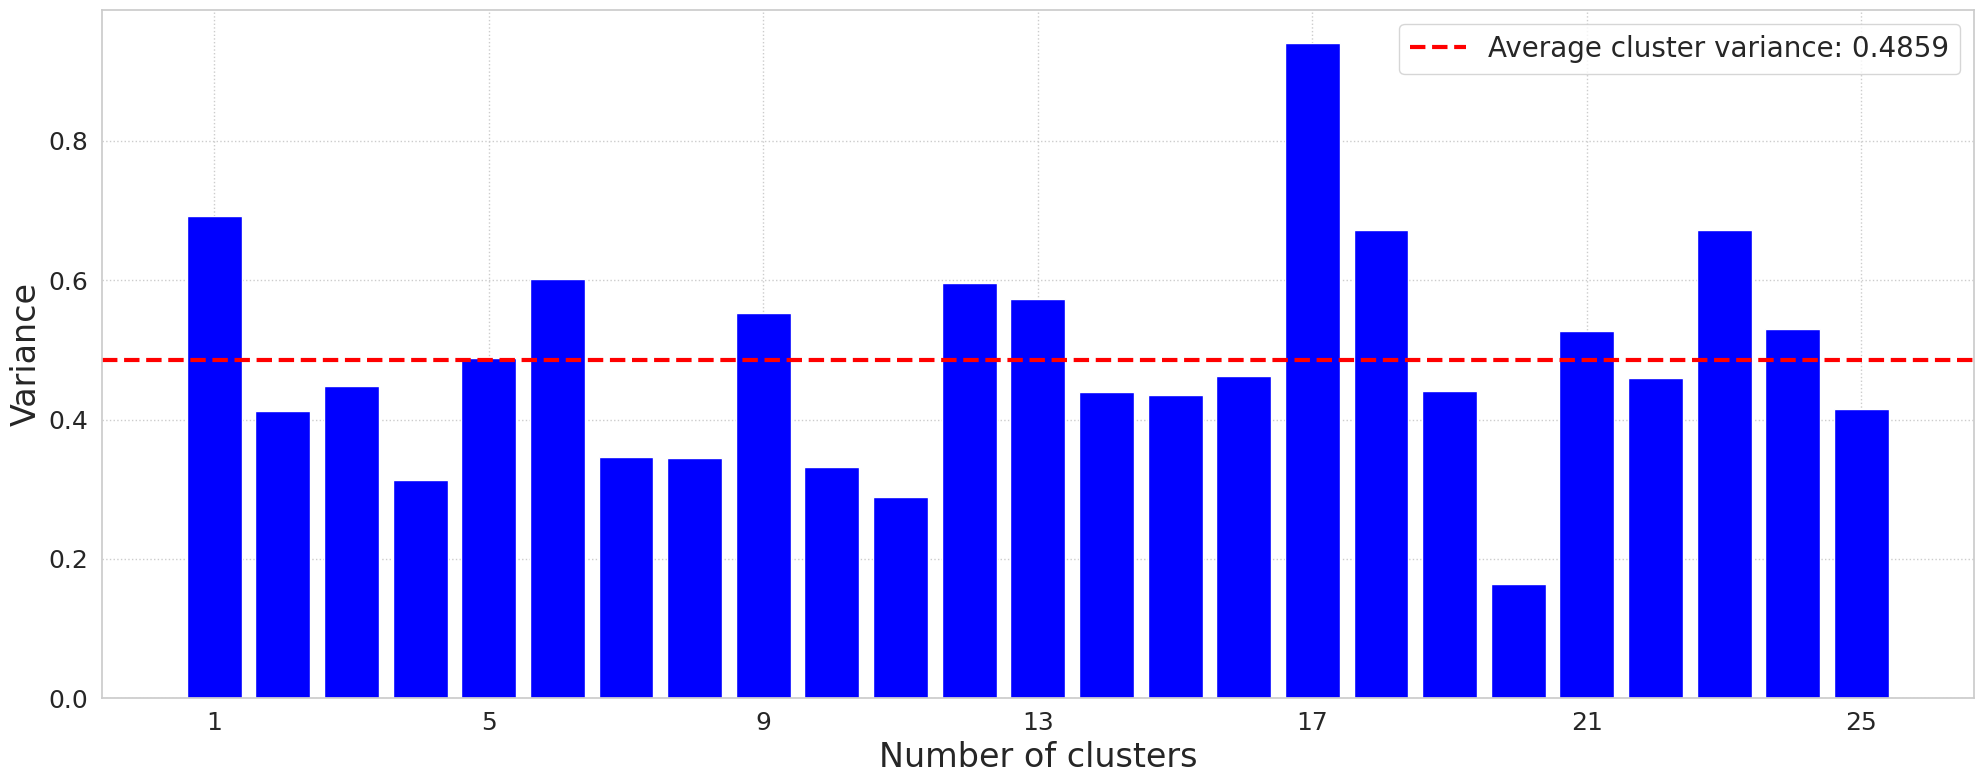

In [48]:
# Nombre de clusters
from sklearn.preprocessing import StandardScaler
k = 25

# 📌 Normalisation des données (évite des variances énormes)
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[df.columns[21:-1]] = scaler.fit_transform(df[df.columns[21:-1]])

# 📌 Calcul de la variance de chaque cluster
vars = []
for i in range(k):
    tdf = df_scaled[df_scaled['Clusters'] == i]
    
    if not tdf.empty:
        var = np.var(tdf.iloc[:, 21:-1].to_numpy(), axis=0)  # Variance sur les bonnes colonnes
        variance = np.mean(var)  # Utilisation de la moyenne au lieu du produit scalaire
    else:
        variance = 0  # Pour éviter les erreurs

    vars.append(variance)

# 📌 Calcul des valeurs importantes
mean_var = np.mean(vars)
max_var = np.max(vars)
min_var = np.min(vars)

# 📊 Affichage des résultats
print(f"The clustering process yields {k} clusters with a mean variance of {mean_var:.4f} per cluster.")
print(f"The cluster {np.argmax(vars)} has the maximum variance of {max_var:.4f}, while the clusters {np.argmin(vars)} have the minimum variance of {min_var:.4f}.")

# 📊 Tracé du graphe
fig = plt.figure(figsize=(20, 8))
sns.set_style("whitegrid")
plt.bar(range(1, k + 1), vars, color='blue')
plt.axhline(y=mean_var, color='red', linestyle='--', linewidth=3, label=f'Average cluster variance: {mean_var:.4f}')
plt.ylabel('Variance', fontsize=24)
plt.xlabel('Number of clusters', fontsize=24)
plt.xticks(range(1, k + 1, 4), fontsize=18)
plt.yticks(fontsize=18)
plt.grid(linestyle=':')
plt.legend(loc='best', fontsize=20)
plt.tight_layout()
plt.show()


In [49]:
max_var = np.array(vars).max()
min_var = np.array(vars).min()

print('The clustering process yields 25 clusters with a mean variance of {:.4f} per cluster.\nThe cluster 8 has the maximum variance of {:.4f}, while the clusters \
15 and 22 have the minimum variance of {:.4f}.'.format(mean_var, max_var, min_var))

The clustering process yields 25 clusters with a mean variance of 0.4859 per cluster.
The cluster 8 has the maximum variance of 0.9407, while the clusters 15 and 22 have the minimum variance of 0.1644.


### Evaluating the average variance contributions

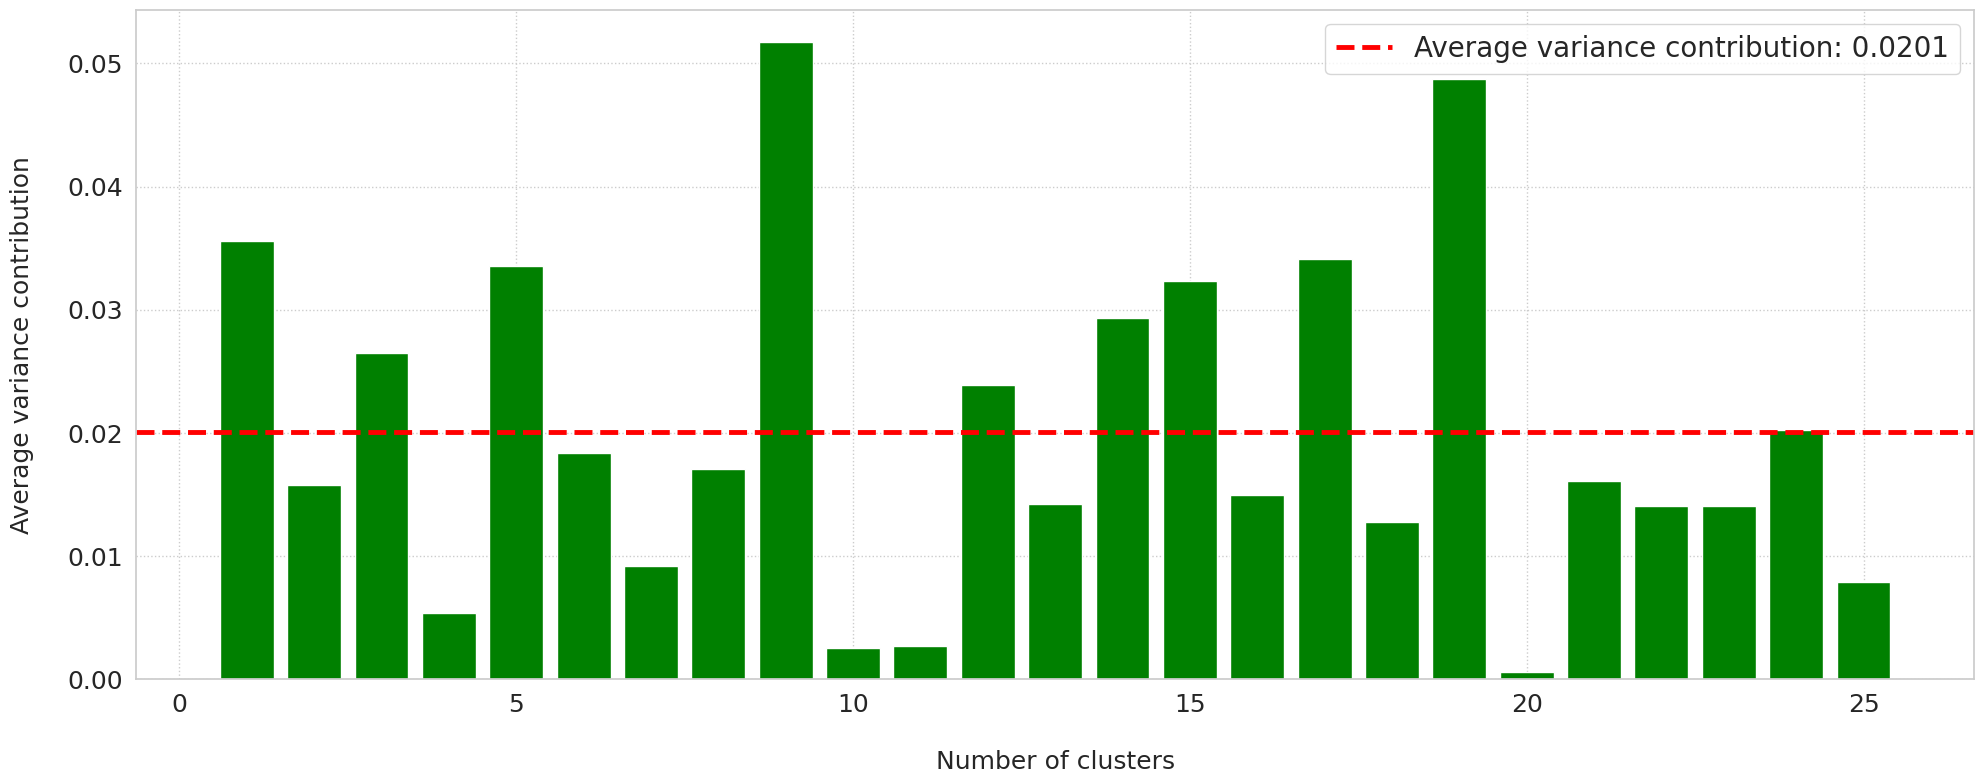

In [50]:
num_clusters = 25
total_size = len(df)
var_contrib = []
for i in range(num_clusters):
    size = len(df[df['Clusters']==i])
    variance = vars[i]
    sample_size = (size * variance) / total_size
    var_contrib.append(sample_size)
    
mean_contrib = np.array(var_contrib).mean()

x = []
for i in range(1,k+1):
    x.append(i)

font = {'size': 10}
fig = plt.figure(figsize=(20,8))
sns.set_style("whitegrid")
plt.bar(x, var_contrib, color='green')
plt.axhline(y = mean_contrib, color = 'red', linestyle = '--', linewidth=3.5, label=f'Average variance contribution: {mean_contrib:.4f}')
plt.ylabel('Average variance contribution\n', fontsize=18)
plt.xlabel('\nNumber of clusters', fontsize=18)
plt.xticks([k for k in range(0,k+1,5)], fontsize=18)
plt.yticks(fontsize=18)
plt.grid(linestyle= ':')
plt.legend(loc='best', fontsize=20)
plt.tight_layout()
plt.show()

In [51]:
max_avg = np.array(var_contrib).max()
min_avg = np.array(var_contrib).min()

print('The clustering process yields 25 clusters with a mean variance contribution of {:.4f} per cluster.\nThe cluster 10 has the maximum variance contribution of {:.4f}, while the clusters \
15 and 22 have the minimum variance contribution of {:.4f}.'.format(mean_contrib, max_avg, min_avg))

The clustering process yields 25 clusters with a mean variance contribution of 0.0201 per cluster.
The cluster 10 has the maximum variance contribution of 0.0518, while the clusters 15 and 22 have the minimum variance contribution of 0.0006.


### Normalize the average variance contributions 

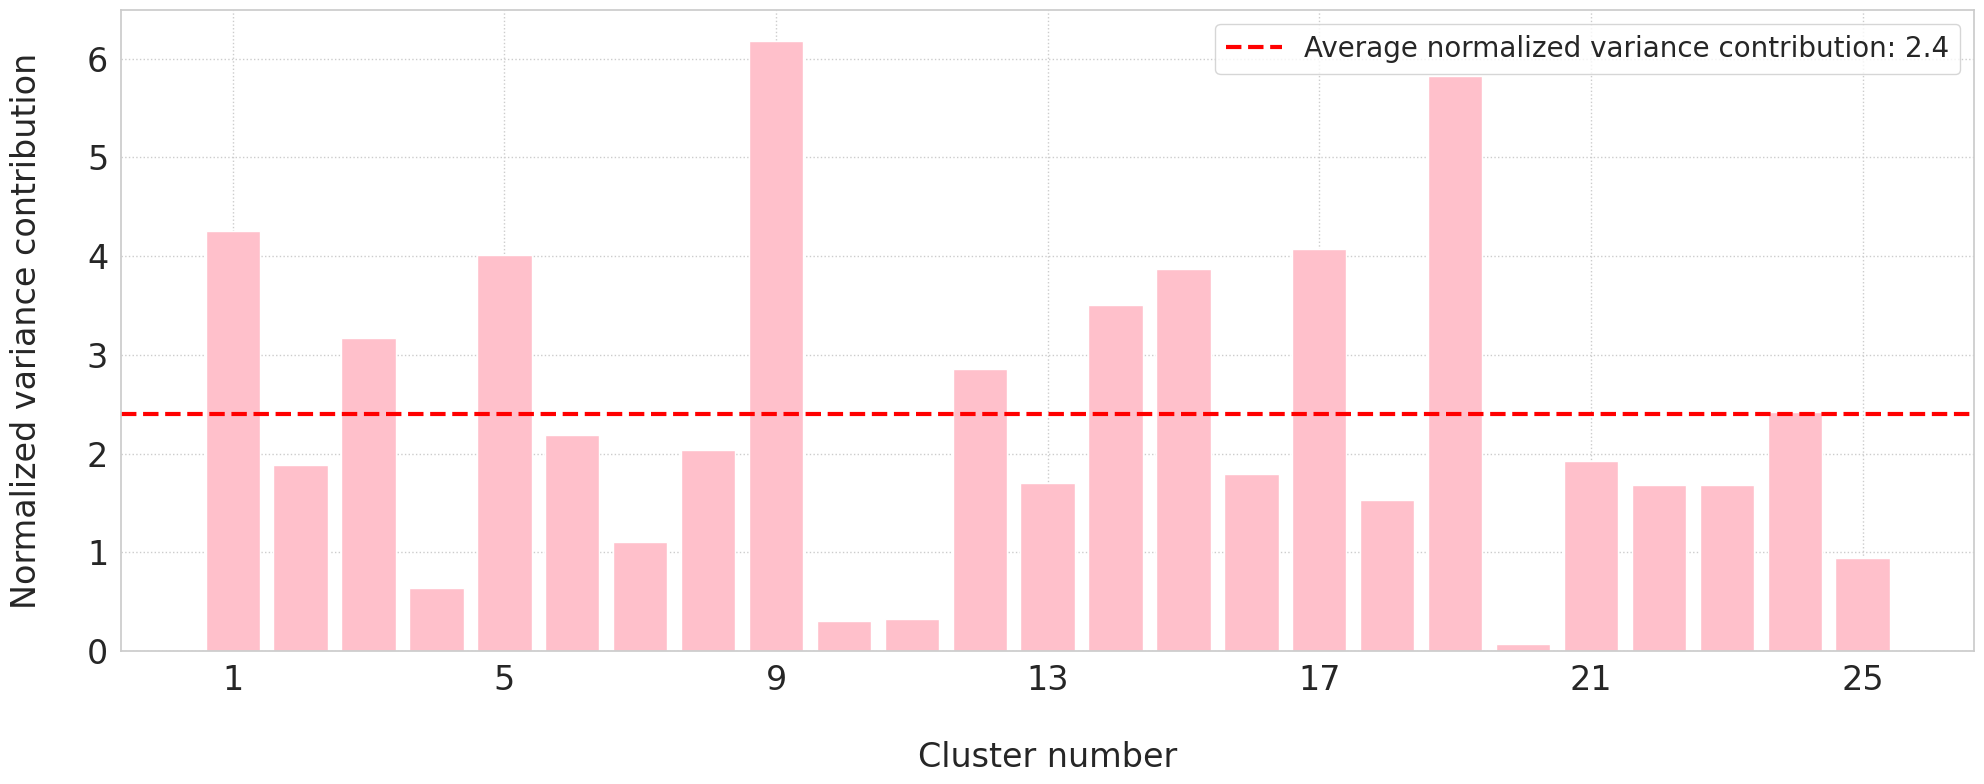

In [52]:
norm_var = []
total_samples = 60
for i in range(len(var_contrib)):
    norm_size = (var_contrib[i] / sum(var_contrib)) * total_samples
    norm_var.append(norm_size)
    
mean_norm = np.array(norm_var).mean()

x = []
for i in range(1,k+1):
    x.append(i)

font = {'size': 20}
fig = plt.figure(figsize=(20,8))
sns.set_style("whitegrid")
plt.bar(x, norm_var, color='pink')
plt.axhline(y = mean_norm, color = 'red', linestyle = '--', linewidth=3, label=f'Average normalized variance contribution: {mean_norm:.1f}')
plt.ylabel('Normalized variance contribution\n', fontsize=24)
plt.xlabel('\nCluster number', fontsize=24)
plt.xticks([k for k in range(1,k+1,4)], fontsize=24)
plt.yticks(fontsize=24)
plt.grid(linestyle= ':')
plt.legend(loc='best', fontsize=20)
plt.tight_layout()
plt.show()

### Infer the number of adequate samples per cluster

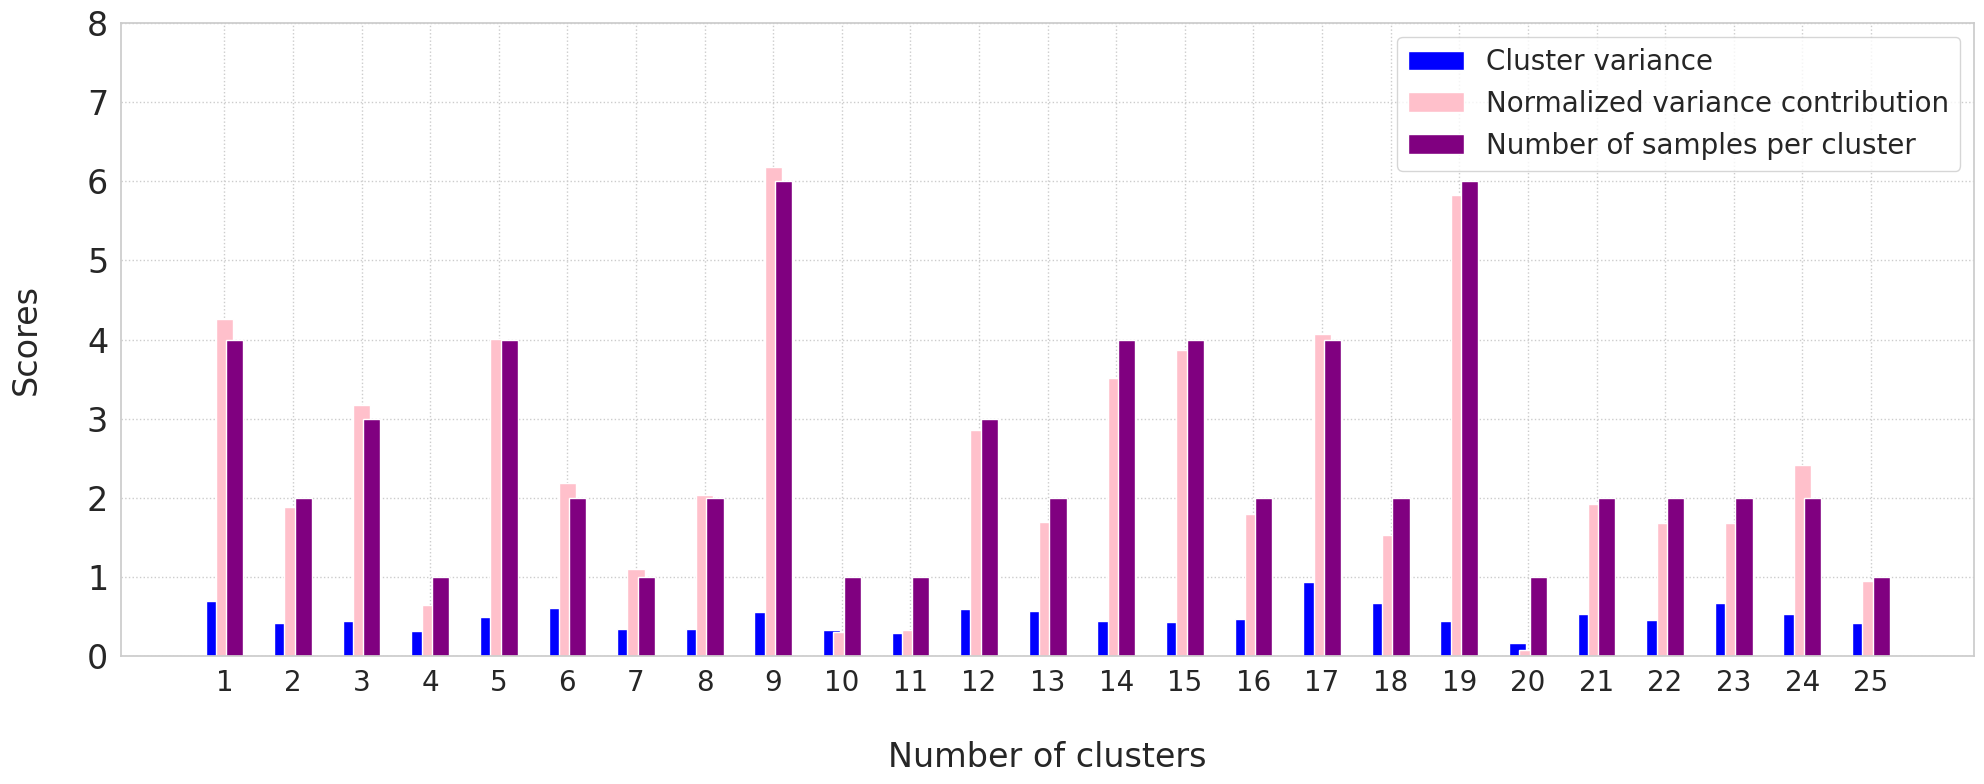

In [53]:
rounded_sizes = []
for i in range(len(norm_var)):
    if int(norm_var[i]) < 1:
        round = 1
    else:
        if int(str(norm_var[i])[2]) < 5:
            round = int(norm_var[i])
        else:
            round = int(norm_var[i]) + 1
    
    rounded_sizes.append(round)
    
x = []
for i in range(1,k+1):
    x.append(i)

width=0.15
y = []
for i in range(len(x)):
    y.append(x[i]+width)

z = []
for i in range(len(y)):
    z.append(y[i]+width)

font = {'size': 10}
fig = plt.figure(figsize=(20,8))
sns.set_style("whitegrid")

bar1 = plt.bar(x, vars, color='blue', width=0.25)
bar2 = plt.bar(y, norm_var, color='pink', width=0.25)
bar3 = plt.bar(z, rounded_sizes, color='purple', width=0.25)

plt.ylabel('Scores\n', fontsize=24)
plt.xlabel('\nNumber of clusters', fontsize=24)
plt.xticks(y, [k for k in range(1,k+1,1)], fontsize=20)
plt.yticks([k for k in range(0,9)], fontsize=24)
plt.grid(linestyle= ':')
plt.legend((bar1, bar2, bar3), ('Cluster variance', 'Normalized variance contribution', 'Number of samples per cluster'), fontsize=20) 
plt.tight_layout()
# Sauvegarder la figure en PDF
plt.savefig('score_map.pdf', format='pdf')
plt.show()


In [54]:
print('We are about to select a total of {} samples from the database, with a minimum of 1 sample and a maximum of 8 samples for clusters having lower \
and higher \nvariance contribution respectively.'.format(sum(rounded_sizes)) )

We are about to select a total of 64 samples from the database, with a minimum of 1 sample and a maximum of 8 samples for clusters having lower and higher 
variance contribution respectively.


### Select the molecular samples

In [397]:
df

smiles_key  Clusters                SMILES  HOMO(eV)  HOMO_xtb(eV)  \
0       gdb 326        16           O=CC(=O)C=O -7.091287      -11.4928   
1       gdb 723        16           C1=NN=CN=N1 -6.734818      -10.1217   
2      gdb 1587        16        CC(=O)C(=O)C=O -6.772914      -11.2156   
3      gdb 1589        16        NC(=O)C(=O)C=O -6.753866      -11.1089   
4      gdb 2115        16          O=C1CC=CC1=O -6.386512      -10.8568   
..          ...       ...                   ...       ...           ...   
519  gdb 133853         6    OC12C3C1N1CC3N=C21 -5.679016       -9.9375   
520  gdb 133854         3  CC12CC34CC=C(C13)C24 -4.285793       -8.4207   
521  gdb 133858        24    CC1N2C3C4=CCC13C24 -4.606888       -8.6748   
522  gdb 133864        24     C1C2CC3OC4CC1C234 -3.771498       -9.9408   
523  gdb 133866        15     C1C2OC3CC4OC1C234 -4.285793       -8.8939   

     HOMO_DFT(eV)  LUMO(eV)  LUMO_xtb(eV)  LUMO_DFT(eV)   GAP(eV)  ...  \
0       -6.913515 -3.959257       -9.1664     -2.552447  3.132031  ...   
1       -6.471639 -3.050396       -9.5066     -2.868605  3.687143  ...   
2       -6.644032 -3.126588       -9.1516     -2.517150  3.646326  ...   
3       -6.732598 -3.311626       -9.9451     -3.399369  3.442240  ...   
4       -6.429667 -2.587803       -9.2243     -2.655859  3.798709  ...   
..            ...       ...           ...           ...       ...  ...   
519     -5.606204 -2.419092       -8.7319     -2.561790  3.259924  ...   
520     -4.369375 -2.481678       -7.7140     -1.807196  1.804115  ...   
521     -4.602213 -2.832705       -7.9451     -2.068744  1.774182  ...   
522     -5.314896 -1.736086       -8.5677     -1.985876  2.032691  ...   
523     -4.193755 -2.046296       -6.8901     -1.147847  2.239497  ...   

        TSRW10          MW        AMW  WPath  WPol  Zagreb1  Zagreb2  \
0    29.753427   86.000394  10.750049     31     4     20.0     19.0   
1    30.941317   82.027946  10.253493     27     3     24.0     24.0   
2    32.688753  100.016044   9.092368     46     6     26.0     26.0   
3    32.688753  101.011293  10.101129     46     6     26.0     26.0   
4    47.572444   96.021129   8.729194     40     5     32.0     35.0   
..         ...         ...        ...    ...   ...      ...      ...   
519  66.384029  122.048013   8.136534     67     5     70.0    100.0   
520  62.143269  118.078250   6.214645     70     6     72.0    104.0   
521  61.908503  119.073499   6.615194     71     7     70.0    102.0   
522  44.269937  122.073165   6.424903     72     8     68.0     96.0   
523  44.269937  124.052429   7.297202     72     8     68.0     96.0   

     mZagreb1  mZagreb2      Id  
0    3.611111  1.666667     326  
1    1.500000  1.500000     723  
2    4.472222  1.777778    1587  
3    4.472222  1.777778    1589  
4    2.972222  1.611111    2115  
..        ...       ...     ...  
519  2.118056  1.611111  133853  
520  2.208333  1.597222  133854  
521  2.118056  1.680556  133858  
522  1.506944  1.666667  133864  
523  1.506944  1.666667  133866  

[524 rows x 1047 columns]

In [398]:
rounded_sizes

[4, 2, 3, 1, 4, 2, 1, 2, 6, 1, 1, 3, 2, 4, 4, 2, 4, 2, 6, 1, 2, 2, 2, 2, 1]

In [399]:
for i, size in enumerate(rounded_sizes):

    cluster_name = i   
    print(size)


4
2
3
1
4
2
1
2
6
1
1
3
2
4
4
2
4
2
6
1
2
2
2
2
1


In [400]:
random.seed = 132

k = 25
keys = []
for i in range(k):
    key = f'Cluster {i}'
    keys.append(key)
selected_samples = {key: None for key in keys}
selected_ids = {key: None for key in keys}
selected_samples

{'Cluster 0': None,
 'Cluster 1': None,
 'Cluster 2': None,
 'Cluster 3': None,
 'Cluster 4': None,
 'Cluster 5': None,
 'Cluster 6': None,
 'Cluster 7': None,
 'Cluster 8': None,
 'Cluster 9': None,
 'Cluster 10': None,
 'Cluster 11': None,
 'Cluster 12': None,
 'Cluster 13': None,
 'Cluster 14': None,
 'Cluster 15': None,
 'Cluster 16': None,
 'Cluster 17': None,
 'Cluster 18': None,
 'Cluster 19': None,
 'Cluster 20': None,
 'Cluster 21': None,
 'Cluster 22': None,
 'Cluster 23': None,
 'Cluster 24': None}

In [401]:
centers_ids

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 364,
 364,
 364,
 364,
 364,
 364,
 364,
 364,
 364]

In [402]:
centroid_id 

364

In [55]:
import random
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

k = 25
keys = [f'Cluster {i}' for i in range(k)]
selected_samples = {key: None for key in keys}
selected_ids = {key: None for key in keys}

# Vérification des clusters existants dans df['Clusters']
existing_clusters = df['Clusters'].unique()
missing_clusters = [size for size in rounded_sizes if size not in existing_clusters]

if missing_clusters:
    print("⚠️ Clusters manquants dans df['Clusters'] :", missing_clusters)

for i, size in enumerate(rounded_sizes):
    cluster_name = f'Cluster {i}'  # Nom du cluster

    # Vérifier si le cluster existe dans df['Clusters']
    if i not in existing_clusters:
        print(f"⚠️ Cluster {i} non trouvé dans df['Clusters']. Skipping...")
        continue

    # Sélectionner toutes les molécules appartenant à ce cluster
    mols_df = df[df['Clusters'] == i]
    ids_list = mols_df['Id'].values.tolist()
    mols_list = mols_df['SMILES'].values.tolist()

    if size == 1:
        # Si seulement une molécule doit être sélectionnée, choisir une au hasard
        selected_index = random.randint(0, len(mols_list) - 1)
        selected_samples[cluster_name] = [mols_list[selected_index]]
        selected_ids[cluster_name] = [ids_list[selected_index]]
    
    elif size >= len(mols_list):
        # Si `size` est supérieur ou égal au nombre de molécules disponibles, prendre tout le cluster
        selected_samples[cluster_name] = mols_list
        selected_ids[cluster_name] = ids_list
    
    else:
        # Sélection aléatoire de `size` molécules dans le cluster
        sampled_indices = random.sample(range(len(mols_list)), size)
        selected_samples[cluster_name] = [mols_list[i] for i in sampled_indices]
        selected_ids[cluster_name] = [ids_list[i] for i in sampled_indices]

print("Sélection des échantillons terminée ✅")


Sélection des échantillons terminée ✅


In [56]:
# Trouver les clusters qui ne sont pas présents dans df['Clusters']
missing_clusters = [size for size in rounded_sizes if size not in df['Clusters'].values]

print("Clusters manquants dans df['Clusters'] :", missing_clusters)


Clusters manquants dans df['Clusters'] : []


In [57]:
selected_samples

{'Cluster 0': ['CC(=O)C(=O)C(=O)C#N',
  'NC=[NH+]C1=NC=N[N-]1',
  'NC(=O)C(=O)C(=O)C=O',
  'NC=[NH+][C-](C#N)C#N'],
 'Cluster 1': ['CNC1C(=O)C=CC1=O', 'NC1=COC([O-])=C1C[NH3+]'],
 'Cluster 2': ['NC1=C(N)C(=N)N=NO1',
  'OC1=C(O)N=CC(=N)N1',
  'NC1=C(F)NC(=N)C=N1'],
 'Cluster 3': ['CC12C3C1C1=CC2C3C1'],
 'Cluster 4': ['NC1=CC2=C(N1)ON=N2',
  'O=CC1=CNC(=O)C1=O',
  'CN1N=CC2=C1ON=N2',
  'O=C1C=CC2=C1NN=N2'],
 'Cluster 5': ['C[NH2+]CCC(=O)C([O-])=O', 'CC1CN1CC(=O)C=O'],
 'Cluster 6': ['C1C2=CC3N=C1N1C3C21'],
 'Cluster 7': ['CC1=CC(=O)[CH-]OC1=[NH2+]', 'NC1=NOC(C[NH3+])=C1[O-]'],
 'Cluster 8': ['CN=C1NC=C(F)C=N1',
  'NC(=[NH2+])C1=NOC(=N)[N-]1',
  'NC=[NH+]CC(=O)C([O-])=O',
  'CNC1=NNC(=O)C=N1',
  'COC1=NNC(=N)C=N1',
  'CN=C1NN=C(N1)C=O'],
 'Cluster 9': ['CC1(C)OCC(=O)C1=O'],
 'Cluster 10': ['CC(N(C)C)C(=O)C=O'],
 'Cluster 11': ['CC12CN1CC(=O)C2=O', 'O=C1C2CCC(O2)C1=O', 'O=C1CNCC(=O)C=C1'],
 'Cluster 12': ['NC1=NC2=C(ON=N2)O1', 'CN1N=C2ON=NC2=N1'],
 'Cluster 13': ['CN1N=C(F)C=NC1=N',
  'COC

In [58]:
selected_ids

{'Cluster 0': [53780, 21706, 53787, 10016],
 'Cluster 1': [109422, 31171],
 'Cluster 2': [129643, 26921, 132116],
 'Cluster 3': [66492],
 'Cluster 4': [129860, 49207, 127634, 130590],
 'Cluster 5': [121600, 88935],
 'Cluster 6': [37081],
 'Cluster 7': [74202, 130404],
 'Cluster 8': [133015, 129393, 97325, 128312, 128673, 127930],
 'Cluster 9': [64068],
 'Cluster 10': [58180],
 'Cluster 11': [70164, 43129, 47284],
 'Cluster 12': [130009, 127543],
 'Cluster 13': [133232, 111942, 129204, 25383],
 'Cluster 14': [26922, 25386, 25341, 26915],
 'Cluster 15': [36994, 133822],
 'Cluster 16': [130667, 2115, 21783, 1589],
 'Cluster 17': [24525, 34480],
 'Cluster 18': [130487, 129006, 24761, 129018, 49206, 130484],
 'Cluster 19': [117630],
 'Cluster 20': [22209, 60718],
 'Cluster 21': [125630, 126880],
 'Cluster 22': [22979, 23066],
 'Cluster 23': [55611, 116525],
 'Cluster 24': [41215]}

In [59]:
with open('semiconductor_qm9_clustering/selected_samples.pkl', 'wb') as f:
    pickle.dump(selected_samples, f)

with open('semiconductor_qm9_clustering/selected_ids.pkl', 'wb') as f:
    pickle.dump(selected_ids, f)

In [60]:
with open('semiconductor_qm9_clustering/selected_samples.pkl', 'rb') as f:
    selected_samples = pickle.load(f)
selected_samples

{'Cluster 0': ['CC(=O)C(=O)C(=O)C#N',
  'NC=[NH+]C1=NC=N[N-]1',
  'NC(=O)C(=O)C(=O)C=O',
  'NC=[NH+][C-](C#N)C#N'],
 'Cluster 1': ['CNC1C(=O)C=CC1=O', 'NC1=COC([O-])=C1C[NH3+]'],
 'Cluster 2': ['NC1=C(N)C(=N)N=NO1',
  'OC1=C(O)N=CC(=N)N1',
  'NC1=C(F)NC(=N)C=N1'],
 'Cluster 3': ['CC12C3C1C1=CC2C3C1'],
 'Cluster 4': ['NC1=CC2=C(N1)ON=N2',
  'O=CC1=CNC(=O)C1=O',
  'CN1N=CC2=C1ON=N2',
  'O=C1C=CC2=C1NN=N2'],
 'Cluster 5': ['C[NH2+]CCC(=O)C([O-])=O', 'CC1CN1CC(=O)C=O'],
 'Cluster 6': ['C1C2=CC3N=C1N1C3C21'],
 'Cluster 7': ['CC1=CC(=O)[CH-]OC1=[NH2+]', 'NC1=NOC(C[NH3+])=C1[O-]'],
 'Cluster 8': ['CN=C1NC=C(F)C=N1',
  'NC(=[NH2+])C1=NOC(=N)[N-]1',
  'NC=[NH+]CC(=O)C([O-])=O',
  'CNC1=NNC(=O)C=N1',
  'COC1=NNC(=N)C=N1',
  'CN=C1NN=C(N1)C=O'],
 'Cluster 9': ['CC1(C)OCC(=O)C1=O'],
 'Cluster 10': ['CC(N(C)C)C(=O)C=O'],
 'Cluster 11': ['CC12CN1CC(=O)C2=O', 'O=C1C2CCC(O2)C1=O', 'O=C1CNCC(=O)C=C1'],
 'Cluster 12': ['NC1=NC2=C(ON=N2)O1', 'CN1N=C2ON=NC2=N1'],
 'Cluster 13': ['CN1N=C(F)C=NC1=N',
  'COC

In [61]:
with open('semiconductor_qm9_clustering/selected_ids.pkl', 'rb') as f:
    selected_ids = pickle.load(f)
selected_ids

{'Cluster 0': [53780, 21706, 53787, 10016],
 'Cluster 1': [109422, 31171],
 'Cluster 2': [129643, 26921, 132116],
 'Cluster 3': [66492],
 'Cluster 4': [129860, 49207, 127634, 130590],
 'Cluster 5': [121600, 88935],
 'Cluster 6': [37081],
 'Cluster 7': [74202, 130404],
 'Cluster 8': [133015, 129393, 97325, 128312, 128673, 127930],
 'Cluster 9': [64068],
 'Cluster 10': [58180],
 'Cluster 11': [70164, 43129, 47284],
 'Cluster 12': [130009, 127543],
 'Cluster 13': [133232, 111942, 129204, 25383],
 'Cluster 14': [26922, 25386, 25341, 26915],
 'Cluster 15': [36994, 133822],
 'Cluster 16': [130667, 2115, 21783, 1589],
 'Cluster 17': [24525, 34480],
 'Cluster 18': [130487, 129006, 24761, 129018, 49206, 130484],
 'Cluster 19': [117630],
 'Cluster 20': [22209, 60718],
 'Cluster 21': [125630, 126880],
 'Cluster 22': [22979, 23066],
 'Cluster 23': [55611, 116525],
 'Cluster 24': [41215]}

In [62]:
molecule_list = []
for i in range(25):
    cluster_name = f'Cluster {i}'
    for j in range(len(selected_samples[cluster_name])):
        mol = selected_samples[cluster_name][j]
        molecule_list.append(mol)
molecule_list

['CC(=O)C(=O)C(=O)C#N',
 'NC=[NH+]C1=NC=N[N-]1',
 'NC(=O)C(=O)C(=O)C=O',
 'NC=[NH+][C-](C#N)C#N',
 'CNC1C(=O)C=CC1=O',
 'NC1=COC([O-])=C1C[NH3+]',
 'NC1=C(N)C(=N)N=NO1',
 'OC1=C(O)N=CC(=N)N1',
 'NC1=C(F)NC(=N)C=N1',
 'CC12C3C1C1=CC2C3C1',
 'NC1=CC2=C(N1)ON=N2',
 'O=CC1=CNC(=O)C1=O',
 'CN1N=CC2=C1ON=N2',
 'O=C1C=CC2=C1NN=N2',
 'C[NH2+]CCC(=O)C([O-])=O',
 'CC1CN1CC(=O)C=O',
 'C1C2=CC3N=C1N1C3C21',
 'CC1=CC(=O)[CH-]OC1=[NH2+]',
 'NC1=NOC(C[NH3+])=C1[O-]',
 'CN=C1NC=C(F)C=N1',
 'NC(=[NH2+])C1=NOC(=N)[N-]1',
 'NC=[NH+]CC(=O)C([O-])=O',
 'CNC1=NNC(=O)C=N1',
 'COC1=NNC(=N)C=N1',
 'CN=C1NN=C(N1)C=O',
 'CC1(C)OCC(=O)C1=O',
 'CC(N(C)C)C(=O)C=O',
 'CC12CN1CC(=O)C2=O',
 'O=C1C2CCC(O2)C1=O',
 'O=C1CNCC(=O)C=C1',
 'NC1=NC2=C(ON=N2)O1',
 'CN1N=C2ON=NC2=N1',
 'CN1N=C(F)C=NC1=N',
 'COC1C=CC(=O)C1=O',
 'N=C1NN=CC(C=O)=C1',
 'N=C1NC(C=O)=NC=C1',
 'OC1=C(O)N=CC(=N)O1',
 'N=C1OC(C=O)=CC=N1',
 'N=C1OC=CC(C=O)=N1',
 'NC1=C(O)OC(=O)C=N1',
 'C1=C2C3C4C1C1C4C3C21',
 'CC12C3C1C1=CC2=CC31',
 'O=C1N=NOC=C1C#N',
 '

In [63]:
id_list = []
for i in range(25):
    cluster_name = f'Cluster {i}'
    for j in range(len(selected_ids[cluster_name])):
        id = selected_ids[cluster_name][j]
        id_list.append(id)
id_list

[53780,
 21706,
 53787,
 10016,
 109422,
 31171,
 129643,
 26921,
 132116,
 66492,
 129860,
 49207,
 127634,
 130590,
 121600,
 88935,
 37081,
 74202,
 130404,
 133015,
 129393,
 97325,
 128312,
 128673,
 127930,
 64068,
 58180,
 70164,
 43129,
 47284,
 130009,
 127543,
 133232,
 111942,
 129204,
 25383,
 26922,
 25386,
 25341,
 26915,
 36994,
 133822,
 130667,
 2115,
 21783,
 1589,
 24525,
 34480,
 130487,
 129006,
 24761,
 129018,
 49206,
 130484,
 117630,
 22209,
 60718,
 125630,
 126880,
 22979,
 23066,
 55611,
 116525,
 41215]

In [64]:
np.save('selected_sc_qm9_sample_list.npy', molecule_list)
np.save('selected_sc_qm9_id_list.npy', id_list)


In [65]:

molecule_list = np.load('selected_sc_qm9_sample_list.npy')
len(molecule_list)

64

Nombre de molécules : 15
Taille de la matrice de similarité : (15, 15)


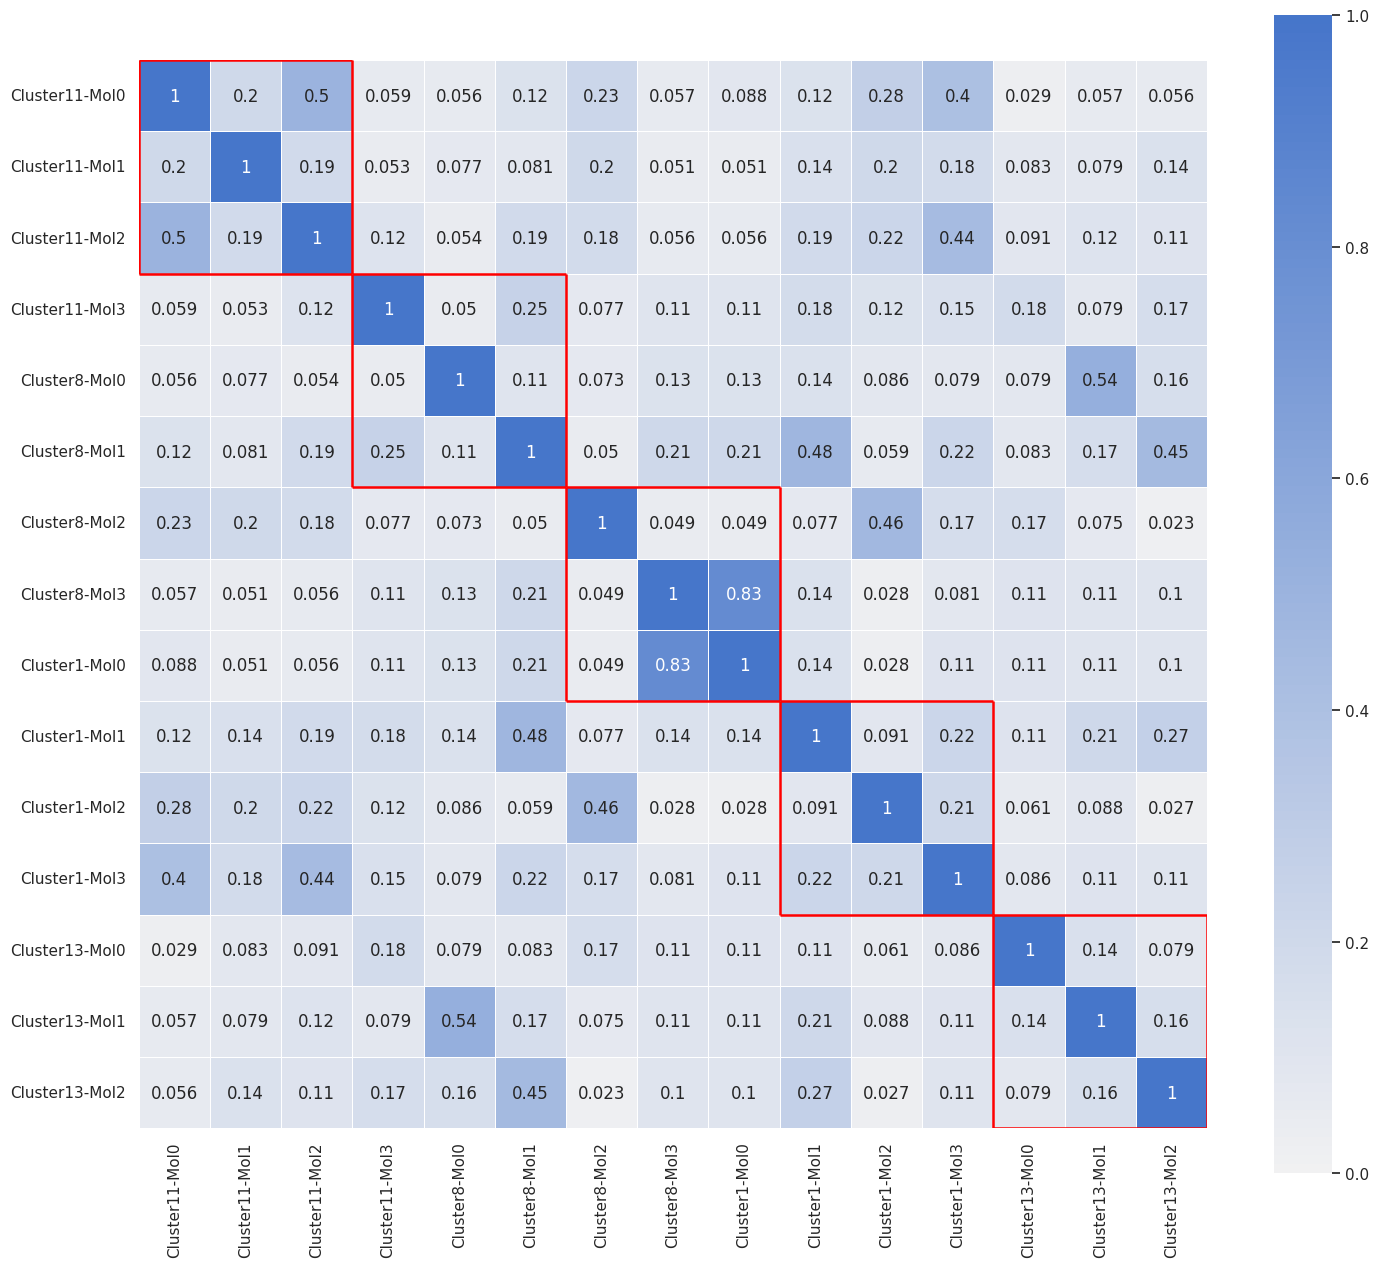

In [66]:
# Générer les objets moléculaires RDKit
molecules = mol_obj(selected_smi_list, rdkit_obj=True)

# Générer les empreintes moléculaires
fingerprints_list = mol_fps(molecules=molecules, rdkit_obj=True)

# Calculer la similarité en paires
similarities = pairwise_similarity(fingerprints_list, rdkit_obj=True)

# Vérification des dimensions
num_molecules = len(molecules)  # Nombre réel de molécules

print(f"Nombre de molécules : {num_molecules}")  # Debug
print(f"Taille de la matrice de similarité : {similarities.shape}")  # Debug

# Ajustement de la liste `labels` pour correspondre à `num_molecules`
labels = [f'Cluster{cluster}-Mol{i}' for cluster in selected_clusters for i in range(4)]
labels = labels[:num_molecules]  # Ajuste la liste des labels si nécessaire

# Vérification finale
assert similarities.shape[0] == similarities.shape[1] == len(labels), "Erreur : La taille de la matrice ne correspond pas aux labels."

# Affichage de la carte de similarité
similarity_map(similarities, labels, annot=True)

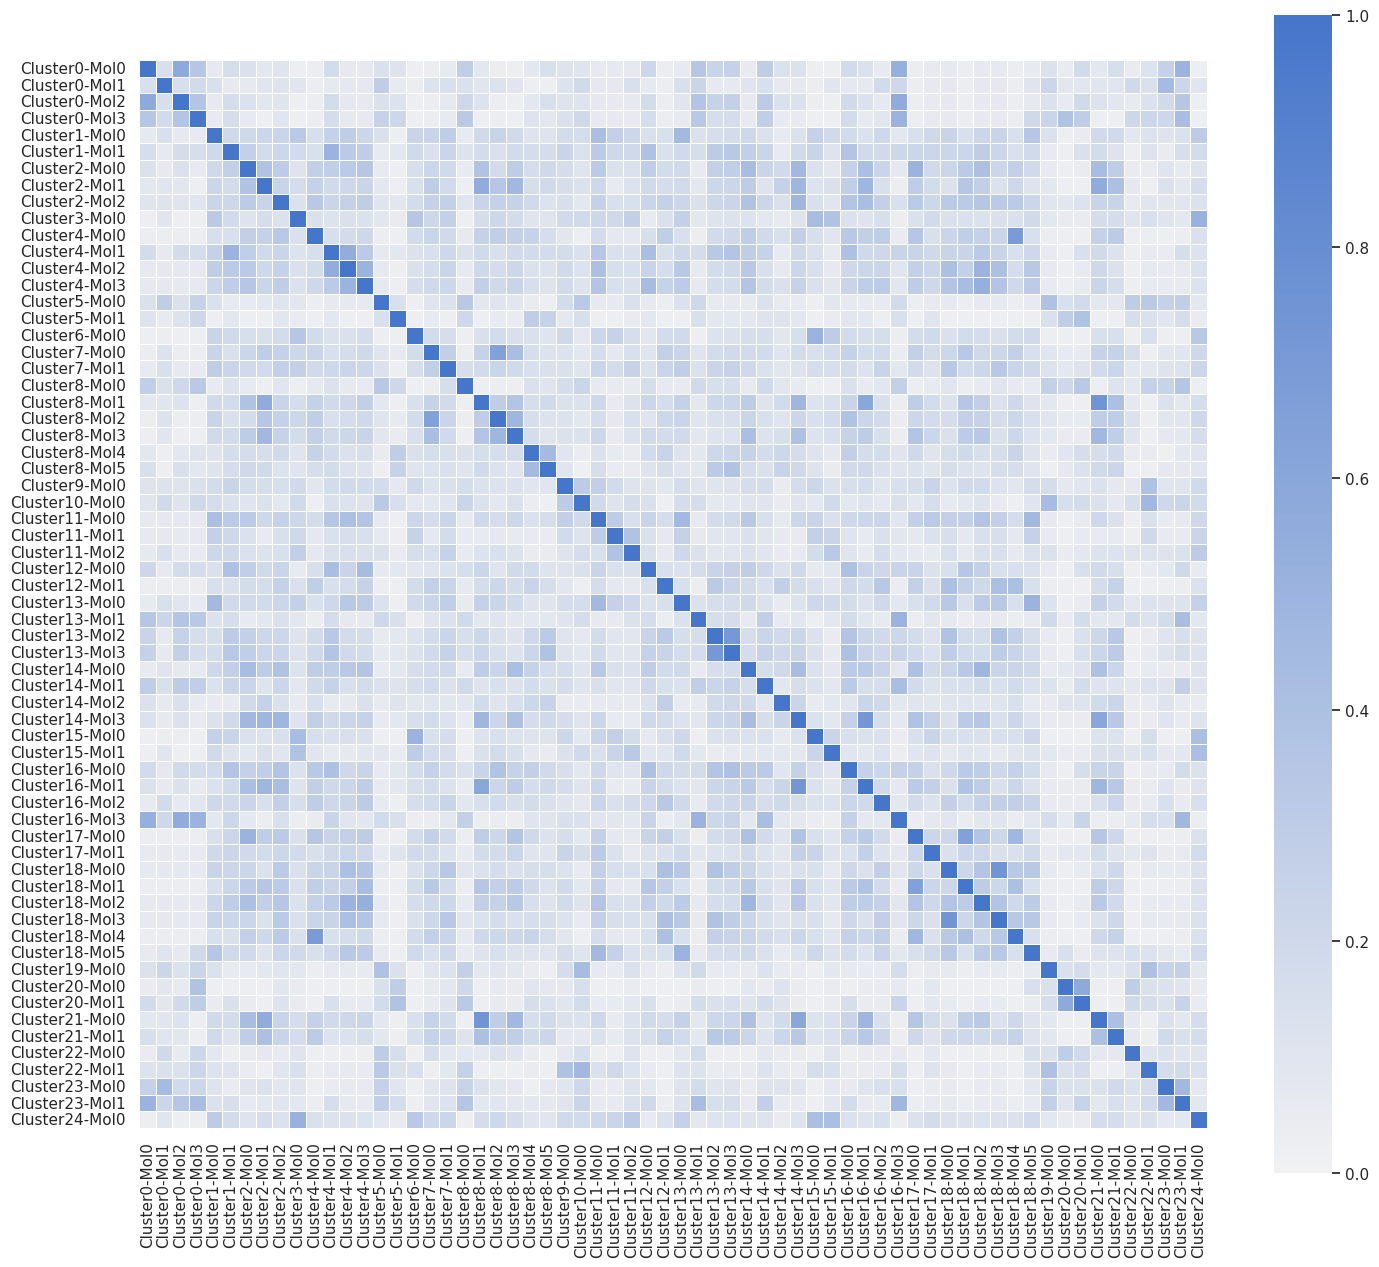

In [415]:
molecules = mol_obj(molecule_list, rdkit_obj=True)
fingerprints_list = mol_fps(molecules=molecules, rdkit_obj=True)
similarities = pairwise_similarity(fingerprints_list, rdkit_obj=True)
labels = [f'Cluster{i}-Mol{j}' for i in range(25) for j in range(len(selected_samples[f'Cluster {i}']))]
assert similarities.shape[0] == similarities.shape[1] == len(labels)
similarity_map(similarities, labels, annot=False)

<div class='alert-success'> Based on the clustering process, we successfully selected 64 representative small molecules of the screened QM9 database containing 216 samples having semiconductor-like bandgap energies. The sample set has been stored using <code>numpy</code> list, as <code>selected_qm9_sample_list.npy</code>.</div>

# **Similarity Maps**

In [201]:
# for key in cluster_df.keys():
#     open('{}_cmps.dat'.format(key), 'x')
#     with open('{}_cmps.dat'.format(key), 'w') as f:
#         for smi in cluster_df[key]:
#             f.write(smi + '\n')
import os

for key in cluster_df.keys():
    filename = f"{key}_cmps.dat"

    # Vérifier si le fichier existe avant de le créer
    if not os.path.exists(filename):
        open(filename, 'x').close()  # Créer un fichier vide

    # Écrire dans le fichier (remplace son contenu s'il existe déjà)
    with open(filename, 'w') as f:
        for smi in cluster_df[key]:
            f.write(smi + "\n")  # Ajouter chaque SMILES sur une nouvelle ligne

print("✅ Fichiers générés avec succès sans écraser les existants !")


✅ Fichiers générés avec succès sans écraser les existants !


## **Subcluster 0**

### **Get similarity map for fingerprint with `RDKit`**

In [369]:
# hard coded variables
bit_size = 2048
radius = 2

# load reference compound and three test molecules
mols = []
for line in open('SubCluster_15_cmps.dat', 'r'):
    mols.append(Chem.MolFromSmiles(line))

In [370]:
mols

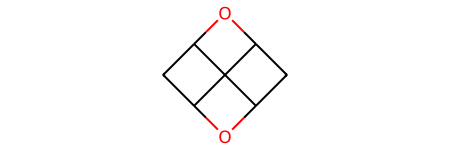

In [371]:
mols[0]

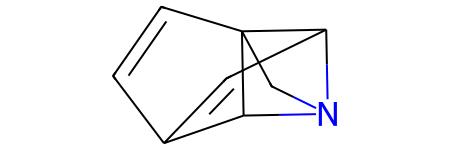

In [372]:
mols[1]

(<Figure size 250x250 with 1 Axes>, 0.09420289855072464)

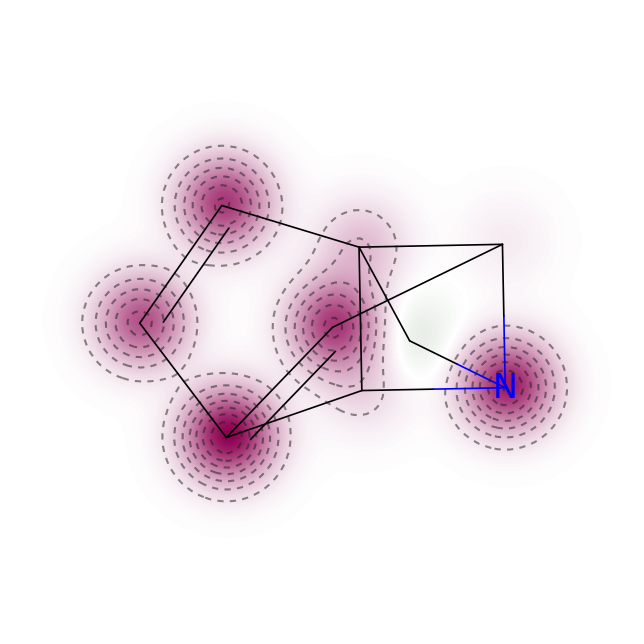

In [373]:
SimilarityMaps.GetSimilarityMapForFingerprint(mols[0], mols[1], SimilarityMaps.GetMorganFingerprint)

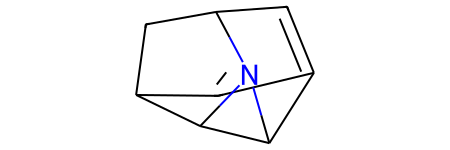

In [374]:
mols[2]

(<Figure size 250x250 with 1 Axes>, 0.07282913165266106)

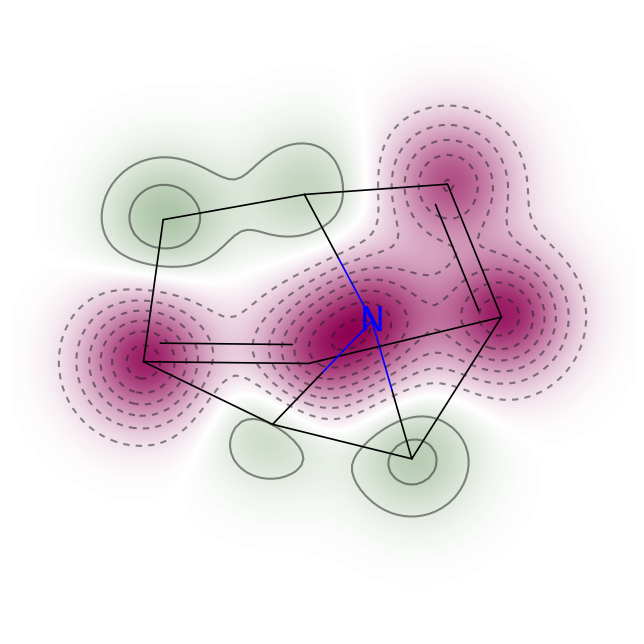

In [375]:
SimilarityMaps.GetSimilarityMapForFingerprint(mols[0], mols[2], SimilarityMaps.GetMorganFingerprint)

(<Figure size 250x250 with 1 Axes>, 0.07282913165266106)

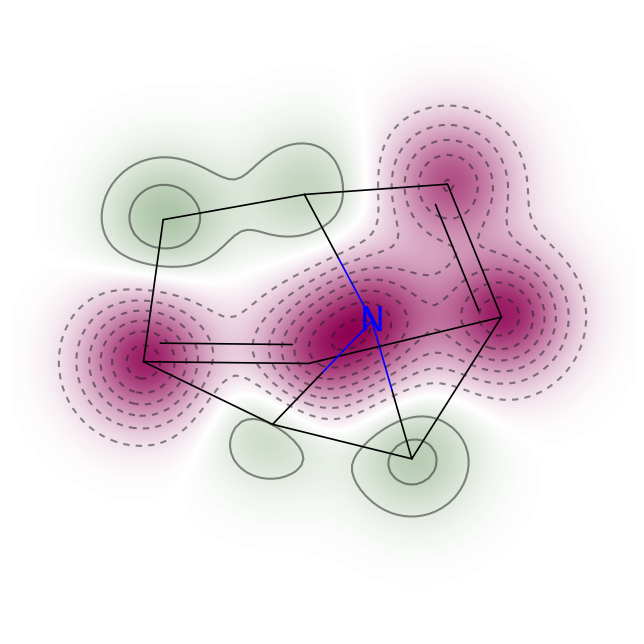

In [376]:
SimilarityMaps.GetSimilarityMapForFingerprint(mols[0], mols[2], SimilarityMaps.GetMorganFingerprint)

### **Get similarity map from weights with `RDKit`**

In [377]:
num_mols

3

In [378]:
# precalculate fingerprints for reference compound
ref_morgan2 = AllChem.GetMorganFingerprintAsBitVect(mols[0], radius, bit_size)

# precalculate fingerprints and bit information for test molecules
fps_morgan2 = []
info_morgan2 = []

num_mols = len(mols) 
nxt_mols = [mols[i] for i in range(num_mols)] # remove reference cmp from list
for m in nxt_mols:
    info = {}
    fps_morgan2.append(AllChem.GetMorganFingerprintAsBitVect(m, radius, bit_size, bitInfo=info))
    info_morgan2.append(info)

### MORGAN2
print ("generate morgan2 similarity maps")
# calculate weights
mol_weights = []
for i,m in enumerate(nxt_mols):
    weights = []
    orig_simil = DataStructs.TanimotoSimilarity(ref_morgan2, fps_morgan2[i])    
    # get bits for each atom
    bitmap = [~DataStructs.ExplicitBitVect(2048) for x in range(m.GetNumAtoms())]
    for bit, es in info_morgan2[i].items():
        for at1, rad in es:
            if rad == 0: # for radius 0
                bitmap[at1][bit] = 0
            else: # for radii > 0
                env = Chem.FindAtomEnvironmentOfRadiusN(m, rad, at1)
                amap = {}
                submol = Chem.PathToSubmol(m, env, atomMap=amap)
                for at2 in amap.keys():
                    bitmap[at2][bit] = 0
    # loop over atoms
    for at1 in range(m.GetNumAtoms()):
        new_fp = fps_morgan2[i] & bitmap[at1]
        new_simil = DataStructs.TanimotoSimilarity(ref_morgan2, new_fp)
        weights.append(orig_simil-new_simil)
    mol_weights.append(weights)

def getNormalizedWeights(weights):
    '''Normalizes a set of weight vectors'''
    for i in range(len(weights)):
        tmp = [math.fabs(j) for j in weights[i]]
        current_max = max(tmp)
        weights[i] = [j/current_max for j in weights[i]]
    return weights

    
# normalization
mol_weights = getNormalizedWeights(mol_weights)

generate morgan2 similarity maps


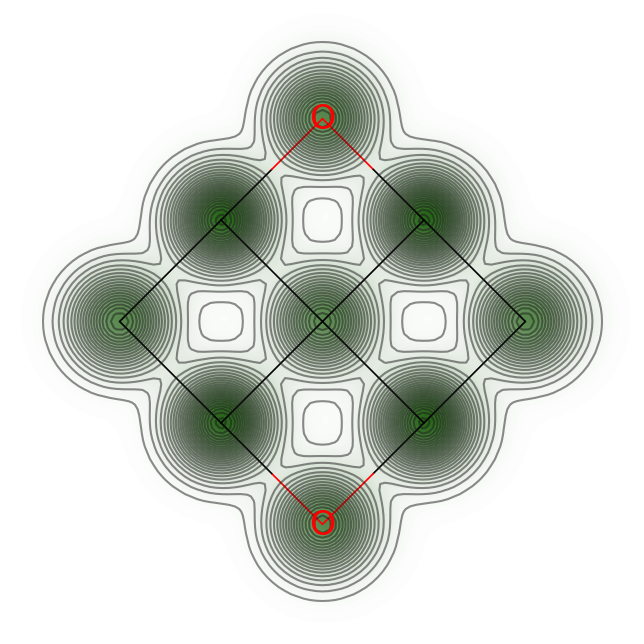

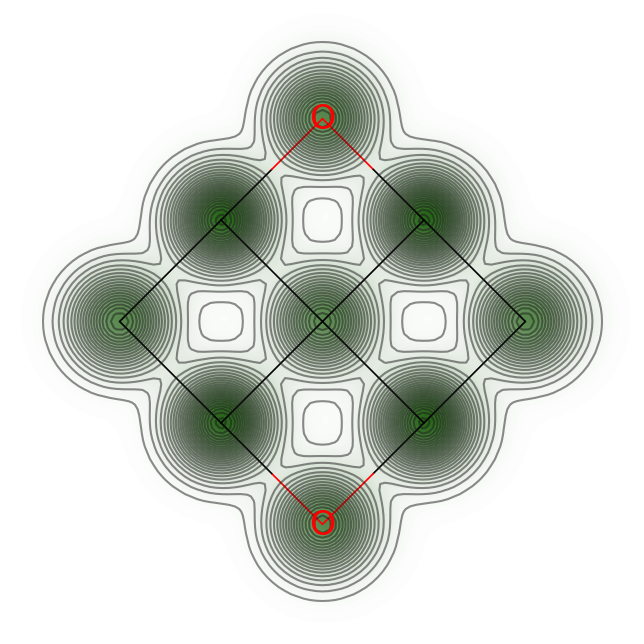

In [379]:
SimilarityMaps.GetSimilarityMapFromWeights(nxt_mols[0], mol_weights[0], scale=-1, size=(250, 250), sigma=0.05, coordScale=1.5, step=0.01, contourLines=25, alpha=0.5)

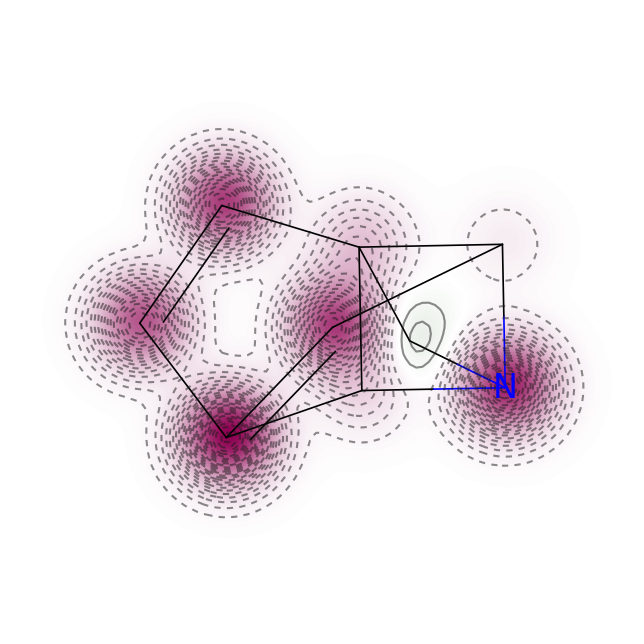

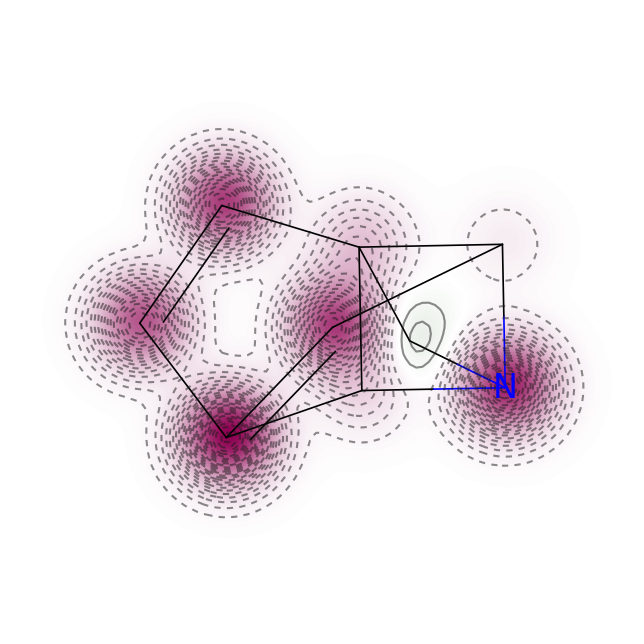

In [380]:
SimilarityMaps.GetSimilarityMapFromWeights(nxt_mols[1], mol_weights[1], scale=-1, size=(250, 250), sigma=0.05, coordScale=1.5, step=0.01, contourLines=30, alpha=0.5)

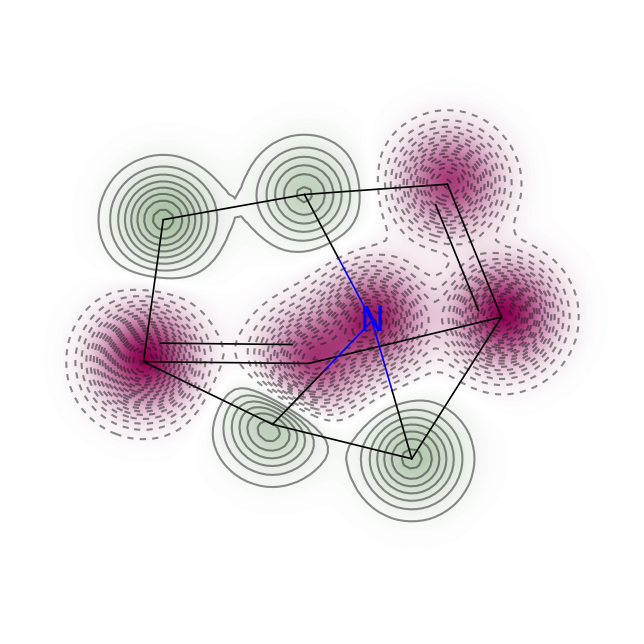

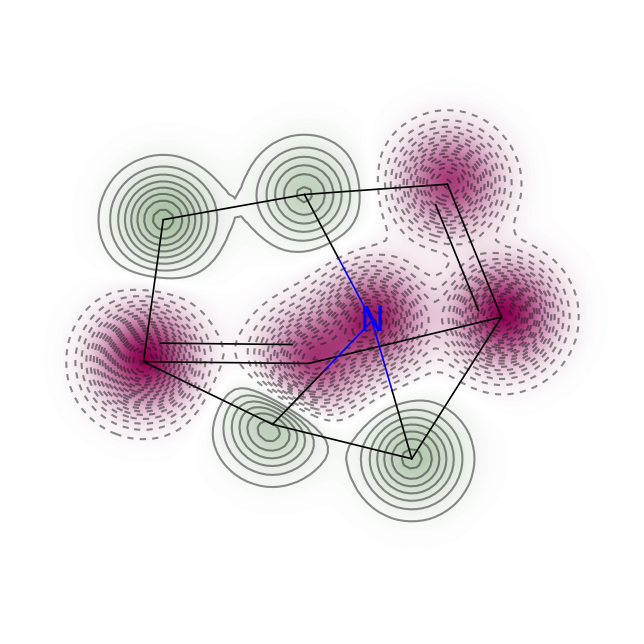

In [381]:
SimilarityMaps.GetSimilarityMapFromWeights(nxt_mols[2], mol_weights[2], scale=-1, size=(250, 250), sigma=0.05, coordScale=1.5, step=0.01, colors='k', contourLines=30, alpha=0.5)